# Predicting The Dataset Using SAHI
## 切片（小图）数据预测

In [10]:
model_path = "/workspace/models/runs_yolov11/output/good/yolo11n-seg.pt---data_split_0.6_0.2_0.2_4---0.913/weights/best.pt"

In [11]:
from sahi import AutoDetectionModel

detection_model = AutoDetectionModel.from_pretrained(
    model_type="ultralytics",
    model_path=model_path,
    confidence_threshold=0.3,
    device="cuda:0",  # or 'cuda:0'
)

In [16]:
from sahi.predict import get_prediction
from sahi.utils.cv import read_image

# With an image path
result = get_prediction("/workspace/models/runs_yolov11/data/data_split_0.4_0.3_0.3/test/images/0828_0633_580_jpg.rf.793c961f03bb7c8a3fd3ced3a1d5c601_73_512_512_1152_1152.png", detection_model)

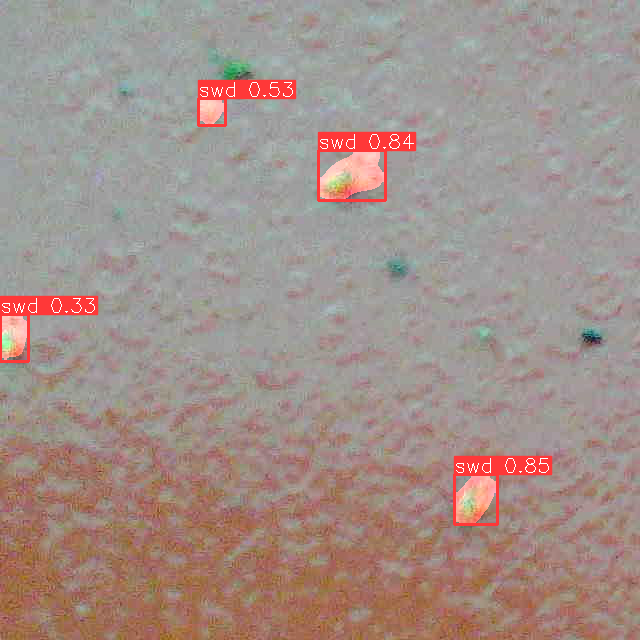

In [ ]:
from PIL import Image as PILImage

result.export_visuals(export_dir="/workspace/models/runs_yolov11/demo_data/")
image = PILImage.open("/workspace/models/runs_yolov11/demo_data/prediction_visual.png")
image = image.resize((640, 640))
image.show()

## 原图（大图）预测

In [1]:
model_path = "/workspace/models/runs_yolov11/output/good/yolo11n-seg.pt---data_split_0.6_0.2_0.2_4---0.913/weights/best.pt"

In [2]:
from sahi import AutoDetectionModel

detection_model = AutoDetectionModel.from_pretrained(
    model_type="ultralytics",
    model_path=model_path,
    confidence_threshold=0.8,
    device="cuda:0",  # or 'cuda:0'
)

In [7]:
from sahi.predict import get_sliced_prediction
image_path = "/workspace/models/SAHI/run_v7/air1_0729-0813_5/raw_data/0805_1254_580.jpg"
result = get_sliced_prediction(
    image_path,
    detection_model,
    slice_height=640,
    slice_width=640,
    overlap_height_ratio=0.2,
    overlap_width_ratio=0.2,
)

Performing prediction on 63 slices.


In [9]:
import os
import json

# =========================
# 转换成 COCO annotation 格式
# =========================
annotations = []
images = []
output_json = "/workspace/models/runs_yolov11/demo_data2/0711_0931_540_predictions.json"

image_id = os.path.splitext(os.path.basename(image_path))[0]
width = result.image_width
height = result.image_height

# 添加 image 信息
images.append({
    "id": image_id,
    "file_name": os.path.basename(image_path),
    "width": width,
    "height": height,
})

# 添加 detection 结果
for idx, obj in enumerate(result.object_prediction_list):
    # bbox: [x_min, y_min, width, height]
    bbox = obj.bbox.to_xywh()
    annotations.append({
        "id": idx,
        "image_id": image_id,
        "category_id": obj.category.id,
        "category_name": obj.category.name,
        "bbox": [float(b) for b in bbox],
        "score": float(obj.score.value),
        "area": float(bbox[2] * bbox[3]),
        "iscrowd": 0
    })

# 组织成 COCO-like dict
coco_output = {
    "images": images,
    "annotations": annotations,
    "categories": [
        {"id": k, "name": v} for k, v in detection_model.category_mapping.items()
    ]
}

# 保存到 json
with open(output_json, "w", encoding="utf-8") as f:
    json.dump(coco_output, f, indent=2)

print(f"保存完成: {output_json}")

保存完成: /workspace/models/runs_yolov11/demo_data2/0711_0931_540_predictions.json


保存完成: /workspace/models/runs_yolov11/demo_data2/prediction_visual.png


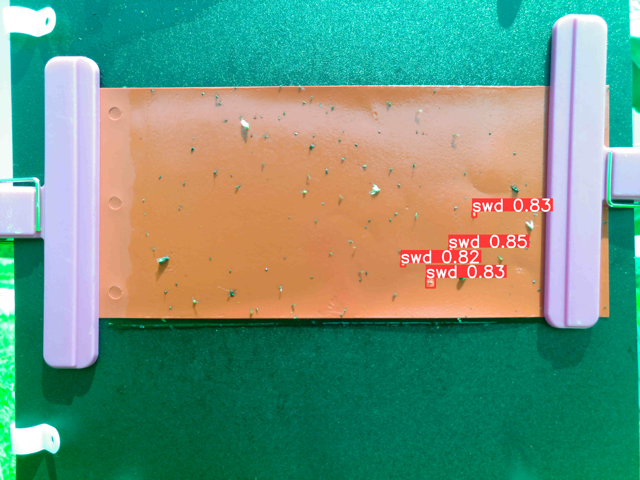

In [10]:
from PIL import Image as PILImage

result.export_visuals(export_dir="/workspace/models/runs_yolov11/demo_data2/")
print("保存完成: /workspace/models/runs_yolov11/demo_data2/prediction_visual.png")
# 压缩图片大小到 640，然后展示
image = PILImage.open("/workspace/models/runs_yolov11/demo_data2/prediction_visual.png")
image = image.resize((640, 480))
image.show()


# 批量预测

In [12]:
import os
import json
from tqdm import tqdm
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction
import pandas as pd

# -------------------
# 参数
# -------------------
model_path = "/workspace/models/runs_yolov11/output/good/yolo11n-seg.pt---data_split_0.6_0.2_0.2_4---0.913/weights/best.pt"
input_dir = "/workspace/models/SAHI/filtered_images"
base_output_dir = "/workspace/models/runs_yolov11/pred"

# 要测试的不同 confidence_threshold
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# -------------------
# 循环每个阈值
# -------------------
for thr in thresholds:
    print(f"\n=== Running inference with confidence_threshold={thr} ===")

    # 每个阈值一个独立的输出目录
    output_dir = f"{base_output_dir}_thr{thr}"
    os.makedirs(output_dir, exist_ok=True)

    # 加载模型（每次重新加载以改变阈值）
    detection_model = AutoDetectionModel.from_pretrained(
        model_type="ultralytics",
        model_path=model_path,
        confidence_threshold=thr,
        device="cuda:0",
    )

    annotations = []
    images = []
    pred_counts = []
    ann_id = 0

    # 遍历图片
    for file in tqdm(os.listdir(input_dir)):
        if not file.lower().endswith((".jpg", ".jpeg", ".png")):
            continue
        
        image_path = os.path.join(input_dir, file)
        result = get_sliced_prediction(
            image_path,
            detection_model,
            slice_height=640,
            slice_width=640,
            overlap_height_ratio=0.2,
            overlap_width_ratio=0.2,
        )

        # image info
        image_id = os.path.splitext(file)[0]
        images.append({
            "id": image_id,
            "file_name": file,
            "width": result.image_width,
            "height": result.image_height,
        })

        # detection 结果
        count = 0
        for obj in result.object_prediction_list:
            bbox = obj.bbox.to_xywh()
            annotations.append({
                "id": ann_id,
                "image_id": image_id,
                "category_id": obj.category.id,
                "category_name": obj.category.name,
                "bbox": [float(b) for b in bbox],
                "score": float(obj.score.value),
                "area": float(bbox[2] * bbox[3]),
                "iscrowd": 0
            })
            ann_id += 1
            count += 1

        # 保存预测数量
        pred_counts.append({"image_id": image_id, "file_name": file, "count": count})

        # 保存可视化结果
        result.export_visuals(export_dir=output_dir, file_name=f"{image_id}_pred.png")

    # -------------------
    # 保存 COCO json
    # -------------------
    coco_output = {
        "images": images,
        "annotations": annotations,
        "categories": [
            {"id": k, "name": v} for k, v in detection_model.category_mapping.items()
        ]
    }
    json_path = os.path.join(output_dir, "all_predictions.json")
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(coco_output, f, indent=2)

    # -------------------
    # 保存预测数量 CSV
    # -------------------
    df = pd.DataFrame(pred_counts)
    csv_path = os.path.join(output_dir, "prediction_counts.csv")
    df.to_csv(csv_path, index=False)

    print(f"✅ 完成: 阈值 {thr}")
    print(f"   - COCO 结果: {json_path}")
    print(f"   - 数量统计: {csv_path}")
    print(f"   - 可视化目录: {output_dir}")



=== Running inference with confidence_threshold=0.1 ===


  0%|          | 0/140 [00:00<?, ?it/s]

Performing prediction on 63 slices.


  1%|          | 1/140 [00:33<1:16:33, 33.05s/it]

Performing prediction on 63 slices.


  1%|▏         | 2/140 [00:44<46:04, 20.04s/it]  

Performing prediction on 63 slices.


  2%|▏         | 3/140 [00:54<35:39, 15.62s/it]

Performing prediction on 63 slices.


  3%|▎         | 4/140 [01:05<31:38, 13.96s/it]

Performing prediction on 63 slices.


  4%|▎         | 5/140 [01:17<29:34, 13.15s/it]

Performing prediction on 63 slices.


  4%|▍         | 6/140 [01:31<29:47, 13.34s/it]

Performing prediction on 63 slices.


  5%|▌         | 7/140 [01:45<30:13, 13.64s/it]

Performing prediction on 63 slices.


  6%|▌         | 8/140 [02:03<33:17, 15.13s/it]

Performing prediction on 63 slices.


  6%|▋         | 9/140 [02:23<36:04, 16.53s/it]

Performing prediction on 63 slices.


  7%|▋         | 10/140 [02:38<35:03, 16.18s/it]

Performing prediction on 63 slices.


  8%|▊         | 11/140 [02:54<34:27, 16.03s/it]

Performing prediction on 63 slices.


  9%|▊         | 12/140 [03:10<33:56, 15.91s/it]

Performing prediction on 63 slices.


  9%|▉         | 13/140 [03:24<32:23, 15.30s/it]

Performing prediction on 63 slices.


 10%|█         | 14/140 [03:35<29:49, 14.20s/it]

Performing prediction on 63 slices.


 11%|█         | 15/140 [03:50<30:00, 14.41s/it]

Performing prediction on 63 slices.


 11%|█▏        | 16/140 [04:10<32:54, 15.92s/it]

Performing prediction on 63 slices.


 12%|█▏        | 17/140 [04:31<36:02, 17.58s/it]

Performing prediction on 63 slices.


 13%|█▎        | 18/140 [05:05<45:51, 22.55s/it]

Performing prediction on 63 slices.


 14%|█▎        | 19/140 [05:46<56:28, 28.00s/it]

Performing prediction on 63 slices.


 14%|█▍        | 20/140 [06:18<58:46, 29.39s/it]

Performing prediction on 63 slices.


 15%|█▌        | 21/140 [06:30<47:50, 24.12s/it]

Performing prediction on 63 slices.


 16%|█▌        | 22/140 [06:44<41:25, 21.07s/it]

Performing prediction on 63 slices.


 16%|█▋        | 23/140 [07:00<37:44, 19.35s/it]

Performing prediction on 63 slices.


 17%|█▋        | 24/140 [07:20<37:51, 19.58s/it]

Performing prediction on 63 slices.


 18%|█▊        | 25/140 [07:36<35:26, 18.50s/it]

Performing prediction on 63 slices.


 19%|█▊        | 26/140 [07:52<34:01, 17.91s/it]

Performing prediction on 63 slices.


 19%|█▉        | 27/140 [08:25<42:22, 22.50s/it]

Performing prediction on 63 slices.


 20%|██        | 28/140 [09:02<49:54, 26.74s/it]

Performing prediction on 63 slices.


 21%|██        | 29/140 [09:42<57:02, 30.83s/it]

Performing prediction on 63 slices.


 21%|██▏       | 30/140 [10:03<50:49, 27.72s/it]

Performing prediction on 63 slices.


 22%|██▏       | 31/140 [10:19<44:12, 24.34s/it]

Performing prediction on 63 slices.


 23%|██▎       | 32/140 [10:35<39:23, 21.89s/it]

Performing prediction on 63 slices.


 24%|██▎       | 33/140 [10:56<38:27, 21.56s/it]

Performing prediction on 63 slices.


 24%|██▍       | 34/140 [11:15<36:46, 20.82s/it]

Performing prediction on 63 slices.


 25%|██▌       | 35/140 [11:42<39:23, 22.51s/it]

Performing prediction on 63 slices.


 26%|██▌       | 36/140 [12:08<40:45, 23.52s/it]

Performing prediction on 63 slices.


 26%|██▋       | 37/140 [12:26<37:39, 21.94s/it]

Performing prediction on 63 slices.


 27%|██▋       | 38/140 [12:56<41:32, 24.43s/it]

Performing prediction on 63 slices.


 28%|██▊       | 39/140 [13:29<45:09, 26.83s/it]

Performing prediction on 63 slices.


 29%|██▊       | 40/140 [14:05<49:22, 29.63s/it]

Performing prediction on 63 slices.


 29%|██▉       | 41/140 [14:34<48:30, 29.40s/it]

Performing prediction on 63 slices.


 30%|███       | 42/140 [15:01<47:07, 28.85s/it]

Performing prediction on 63 slices.


 31%|███       | 43/140 [15:06<34:43, 21.48s/it]

Performing prediction on 63 slices.


 31%|███▏      | 44/140 [15:09<25:56, 16.22s/it]

Performing prediction on 63 slices.


 32%|███▏      | 45/140 [15:25<25:10, 15.90s/it]

Performing prediction on 63 slices.


 33%|███▎      | 46/140 [15:34<21:54, 13.99s/it]

Performing prediction on 63 slices.


 34%|███▎      | 47/140 [15:46<20:43, 13.37s/it]

Performing prediction on 63 slices.


 34%|███▍      | 48/140 [15:53<17:35, 11.47s/it]

Performing prediction on 63 slices.


 35%|███▌      | 49/140 [16:07<18:43, 12.35s/it]

Performing prediction on 63 slices.


 36%|███▌      | 50/140 [16:23<19:46, 13.19s/it]

Performing prediction on 63 slices.


 36%|███▋      | 51/140 [16:37<20:17, 13.68s/it]

Performing prediction on 63 slices.


 37%|███▋      | 52/140 [16:56<22:13, 15.16s/it]

Performing prediction on 63 slices.


 38%|███▊      | 53/140 [17:13<22:57, 15.83s/it]

Performing prediction on 63 slices.


 39%|███▊      | 54/140 [17:31<23:20, 16.29s/it]

Performing prediction on 63 slices.


 39%|███▉      | 55/140 [17:52<25:05, 17.72s/it]

Performing prediction on 63 slices.


 40%|████      | 56/140 [18:14<26:49, 19.17s/it]

Performing prediction on 63 slices.


 41%|████      | 57/140 [18:39<28:41, 20.75s/it]

Performing prediction on 63 slices.


 41%|████▏     | 58/140 [19:01<28:59, 21.21s/it]

Performing prediction on 63 slices.


 42%|████▏     | 59/140 [19:21<27:59, 20.74s/it]

Performing prediction on 63 slices.


 43%|████▎     | 60/140 [19:39<26:48, 20.11s/it]

Performing prediction on 63 slices.


 44%|████▎     | 61/140 [19:59<26:21, 20.01s/it]

Performing prediction on 63 slices.


 44%|████▍     | 62/140 [20:20<26:28, 20.36s/it]

Performing prediction on 63 slices.


 45%|████▌     | 63/140 [20:41<26:16, 20.47s/it]

Performing prediction on 63 slices.


 46%|████▌     | 64/140 [21:00<25:21, 20.02s/it]

Performing prediction on 63 slices.


 46%|████▋     | 65/140 [21:20<25:04, 20.06s/it]

Performing prediction on 63 slices.


 47%|████▋     | 66/140 [21:41<24:52, 20.17s/it]

Performing prediction on 63 slices.


 48%|████▊     | 67/140 [22:08<27:09, 22.32s/it]

Performing prediction on 63 slices.


 49%|████▊     | 68/140 [22:36<28:53, 24.08s/it]

Performing prediction on 63 slices.


 49%|████▉     | 69/140 [23:03<29:20, 24.80s/it]

Performing prediction on 63 slices.


 50%|█████     | 70/140 [23:33<30:47, 26.40s/it]

Performing prediction on 63 slices.


 51%|█████     | 71/140 [24:01<31:07, 27.07s/it]

Performing prediction on 63 slices.


 51%|█████▏    | 72/140 [24:27<30:10, 26.62s/it]

Performing prediction on 63 slices.


 52%|█████▏    | 73/140 [24:55<30:03, 26.92s/it]

Performing prediction on 63 slices.


 53%|█████▎    | 74/140 [25:26<31:08, 28.31s/it]

Performing prediction on 63 slices.


 54%|█████▎    | 75/140 [26:02<33:07, 30.58s/it]

Performing prediction on 63 slices.


 54%|█████▍    | 76/140 [26:43<35:46, 33.54s/it]

Performing prediction on 63 slices.


 55%|█████▌    | 77/140 [27:34<40:58, 39.03s/it]

Performing prediction on 63 slices.


 56%|█████▌    | 78/140 [28:50<51:35, 49.92s/it]

Performing prediction on 63 slices.


 56%|█████▋    | 79/140 [29:28<47:06, 46.33s/it]

Performing prediction on 63 slices.


 57%|█████▋    | 80/140 [30:09<44:44, 44.74s/it]

Performing prediction on 63 slices.


 58%|█████▊    | 81/140 [30:52<43:35, 44.33s/it]

Performing prediction on 63 slices.


 59%|█████▊    | 82/140 [31:38<43:17, 44.78s/it]

Performing prediction on 63 slices.


 59%|█████▉    | 83/140 [32:21<42:10, 44.39s/it]

Performing prediction on 63 slices.


 60%|██████    | 84/140 [33:05<41:15, 44.20s/it]

Performing prediction on 63 slices.


 61%|██████    | 85/140 [33:15<31:12, 34.05s/it]

Performing prediction on 63 slices.


 61%|██████▏   | 86/140 [33:57<32:36, 36.23s/it]

Performing prediction on 63 slices.


 62%|██████▏   | 87/140 [34:20<28:33, 32.33s/it]

Performing prediction on 63 slices.


 63%|██████▎   | 88/140 [34:57<29:15, 33.77s/it]

Performing prediction on 63 slices.


 64%|██████▎   | 89/140 [35:31<28:42, 33.78s/it]

Performing prediction on 63 slices.


 64%|██████▍   | 90/140 [36:14<30:34, 36.68s/it]

Performing prediction on 63 slices.


 65%|██████▌   | 91/140 [36:58<31:34, 38.66s/it]

Performing prediction on 63 slices.


 66%|██████▌   | 92/140 [37:41<31:59, 39.98s/it]

Performing prediction on 63 slices.


 66%|██████▋   | 93/140 [37:56<25:24, 32.44s/it]

Performing prediction on 63 slices.


 67%|██████▋   | 94/140 [38:10<20:46, 27.10s/it]

Performing prediction on 63 slices.


 68%|██████▊   | 95/140 [38:27<17:55, 23.90s/it]

Performing prediction on 63 slices.


 69%|██████▊   | 96/140 [38:48<17:02, 23.24s/it]

Performing prediction on 63 slices.


 69%|██████▉   | 97/140 [39:08<15:55, 22.22s/it]

Performing prediction on 63 slices.


 70%|███████   | 98/140 [39:40<17:32, 25.06s/it]

Performing prediction on 63 slices.


 71%|███████   | 99/140 [40:13<18:49, 27.55s/it]

Performing prediction on 63 slices.


 71%|███████▏  | 100/140 [40:45<19:09, 28.74s/it]

Performing prediction on 63 slices.


 72%|███████▏  | 101/140 [41:02<16:30, 25.40s/it]

Performing prediction on 63 slices.


 73%|███████▎  | 102/140 [41:25<15:38, 24.69s/it]

Performing prediction on 63 slices.


 74%|███████▎  | 103/140 [42:01<17:20, 28.11s/it]

Performing prediction on 63 slices.


 74%|███████▍  | 104/140 [42:40<18:44, 31.23s/it]

Performing prediction on 63 slices.


 75%|███████▌  | 105/140 [43:13<18:36, 31.90s/it]

Performing prediction on 63 slices.


 76%|███████▌  | 106/140 [43:55<19:38, 34.65s/it]

Performing prediction on 63 slices.


 76%|███████▋  | 107/140 [44:35<20:00, 36.38s/it]

Performing prediction on 63 slices.


 77%|███████▋  | 108/140 [45:08<18:52, 35.38s/it]

Performing prediction on 63 slices.


 78%|███████▊  | 109/140 [45:45<18:28, 35.74s/it]

Performing prediction on 63 slices.


 79%|███████▊  | 110/140 [46:24<18:23, 36.79s/it]

Performing prediction on 63 slices.


 79%|███████▉  | 111/140 [47:02<18:00, 37.27s/it]

Performing prediction on 63 slices.


 80%|████████  | 112/140 [47:42<17:42, 37.96s/it]

Performing prediction on 63 slices.


 81%|████████  | 113/140 [48:18<16:53, 37.53s/it]

Performing prediction on 63 slices.


 81%|████████▏ | 114/140 [48:56<16:17, 37.59s/it]

Performing prediction on 63 slices.


 82%|████████▏ | 115/140 [49:36<15:58, 38.33s/it]

Performing prediction on 63 slices.


 83%|████████▎ | 116/140 [50:54<20:03, 50.14s/it]

Performing prediction on 63 slices.


 84%|████████▎ | 117/140 [52:00<21:03, 54.93s/it]

Performing prediction on 63 slices.


 84%|████████▍ | 118/140 [52:25<16:52, 46.02s/it]

Performing prediction on 63 slices.


 85%|████████▌ | 119/140 [53:04<15:21, 43.86s/it]

Performing prediction on 63 slices.


 86%|████████▌ | 120/140 [53:36<13:29, 40.45s/it]

Performing prediction on 63 slices.


 86%|████████▋ | 121/140 [54:17<12:50, 40.57s/it]

Performing prediction on 63 slices.


 87%|████████▋ | 122/140 [54:53<11:44, 39.14s/it]

Performing prediction on 63 slices.


 88%|████████▊ | 123/140 [55:02<08:32, 30.15s/it]

Performing prediction on 63 slices.


 89%|████████▊ | 124/140 [55:30<07:50, 29.41s/it]

Performing prediction on 63 slices.


 89%|████████▉ | 125/140 [56:19<08:50, 35.37s/it]

Performing prediction on 63 slices.


 90%|█████████ | 126/140 [57:07<09:07, 39.12s/it]

Performing prediction on 63 slices.


 91%|█████████ | 127/140 [57:25<07:05, 32.75s/it]

Performing prediction on 63 slices.


 91%|█████████▏| 128/140 [57:43<05:38, 28.25s/it]

Performing prediction on 63 slices.


 92%|█████████▏| 129/140 [57:59<04:29, 24.54s/it]

Performing prediction on 63 slices.


 93%|█████████▎| 130/140 [58:19<03:51, 23.16s/it]

Performing prediction on 63 slices.


 94%|█████████▎| 131/140 [58:34<03:06, 20.75s/it]

Performing prediction on 63 slices.


 94%|█████████▍| 132/140 [58:58<02:54, 21.77s/it]

Performing prediction on 63 slices.


 95%|█████████▌| 133/140 [59:45<03:25, 29.32s/it]

Performing prediction on 63 slices.


 96%|█████████▌| 134/140 [1:00:13<02:54, 29.04s/it]

Performing prediction on 63 slices.


 96%|█████████▋| 135/140 [1:00:41<02:23, 28.76s/it]

Performing prediction on 63 slices.


 97%|█████████▋| 136/140 [1:01:35<02:24, 36.21s/it]

Performing prediction on 63 slices.


 98%|█████████▊| 137/140 [1:02:11<01:48, 36.17s/it]

Performing prediction on 63 slices.


 99%|█████████▊| 138/140 [1:02:26<00:59, 29.96s/it]

Performing prediction on 63 slices.


 99%|█████████▉| 139/140 [1:03:21<00:37, 37.48s/it]

Performing prediction on 63 slices.


100%|██████████| 140/140 [1:03:54<00:00, 27.39s/it]


✅ 完成: 阈值 0.1
   - COCO 结果: /workspace/models/runs_yolov11/pred_thr0.1/all_predictions.json
   - 数量统计: /workspace/models/runs_yolov11/pred_thr0.1/prediction_counts.csv
   - 可视化目录: /workspace/models/runs_yolov11/pred_thr0.1

=== Running inference with confidence_threshold=0.2 ===


  0%|          | 0/140 [00:00<?, ?it/s]

Performing prediction on 63 slices.


  1%|          | 1/140 [00:27<1:03:25, 27.38s/it]

Performing prediction on 63 slices.


  1%|▏         | 2/140 [00:37<40:06, 17.44s/it]  

Performing prediction on 63 slices.


  2%|▏         | 3/140 [00:48<32:37, 14.29s/it]

Performing prediction on 63 slices.


  3%|▎         | 4/140 [00:58<28:34, 12.61s/it]

Performing prediction on 63 slices.


  4%|▎         | 5/140 [01:09<26:50, 11.93s/it]

Performing prediction on 63 slices.


  4%|▍         | 6/140 [01:19<25:12, 11.29s/it]

Performing prediction on 63 slices.


  5%|▌         | 7/140 [01:34<27:39, 12.48s/it]

Performing prediction on 63 slices.


  6%|▌         | 8/140 [01:51<30:39, 13.93s/it]

Performing prediction on 63 slices.


  6%|▋         | 9/140 [02:09<33:03, 15.14s/it]

Performing prediction on 63 slices.


  7%|▋         | 10/140 [02:24<33:05, 15.27s/it]

Performing prediction on 63 slices.


  8%|▊         | 11/140 [02:40<33:31, 15.59s/it]

Performing prediction on 63 slices.


  9%|▊         | 12/140 [02:55<32:16, 15.13s/it]

Performing prediction on 63 slices.


  9%|▉         | 13/140 [03:07<30:05, 14.22s/it]

Performing prediction on 63 slices.


 10%|█         | 14/140 [03:16<26:52, 12.80s/it]

Performing prediction on 63 slices.


 11%|█         | 15/140 [03:29<26:44, 12.83s/it]

Performing prediction on 63 slices.


 11%|█▏        | 16/140 [03:45<28:29, 13.78s/it]

Performing prediction on 63 slices.


 12%|█▏        | 17/140 [04:04<31:34, 15.40s/it]

Performing prediction on 63 slices.


 13%|█▎        | 18/140 [04:29<37:12, 18.30s/it]

Performing prediction on 63 slices.


 14%|█▎        | 19/140 [05:05<47:39, 23.64s/it]

Performing prediction on 63 slices.


 14%|█▍        | 20/140 [05:33<49:25, 24.71s/it]

Performing prediction on 63 slices.


 15%|█▌        | 21/140 [05:43<40:31, 20.43s/it]

Performing prediction on 63 slices.


 16%|█▌        | 22/140 [05:53<33:48, 17.19s/it]

Performing prediction on 63 slices.


 16%|█▋        | 23/140 [06:08<32:14, 16.53s/it]

Performing prediction on 63 slices.


 17%|█▋        | 24/140 [06:22<30:38, 15.85s/it]

Performing prediction on 63 slices.


 18%|█▊        | 25/140 [06:35<28:34, 14.91s/it]

Performing prediction on 63 slices.


 19%|█▊        | 26/140 [06:48<27:31, 14.49s/it]

Performing prediction on 63 slices.


 19%|█▉        | 27/140 [07:13<33:20, 17.71s/it]

Performing prediction on 63 slices.


 20%|██        | 28/140 [07:40<37:48, 20.26s/it]

Performing prediction on 63 slices.


 21%|██        | 29/140 [08:08<42:12, 22.81s/it]

Performing prediction on 63 slices.


 21%|██▏       | 30/140 [08:24<37:57, 20.70s/it]

Performing prediction on 63 slices.


 22%|██▏       | 31/140 [08:37<33:19, 18.35s/it]

Performing prediction on 63 slices.


 23%|██▎       | 32/140 [08:50<30:20, 16.86s/it]

Performing prediction on 63 slices.


 24%|██▎       | 33/140 [09:07<29:41, 16.65s/it]

Performing prediction on 63 slices.


 24%|██▍       | 34/140 [09:24<29:57, 16.96s/it]

Performing prediction on 63 slices.


 25%|██▌       | 35/140 [09:47<32:45, 18.72s/it]

Performing prediction on 63 slices.


 26%|██▌       | 36/140 [10:06<32:49, 18.93s/it]

Performing prediction on 63 slices.


 26%|██▋       | 37/140 [10:24<31:32, 18.38s/it]

Performing prediction on 63 slices.


 27%|██▋       | 38/140 [10:49<34:48, 20.48s/it]

Performing prediction on 63 slices.


 28%|██▊       | 39/140 [11:18<38:33, 22.90s/it]

Performing prediction on 63 slices.


 29%|██▊       | 40/140 [11:49<42:30, 25.50s/it]

Performing prediction on 63 slices.


 29%|██▉       | 41/140 [12:14<41:46, 25.31s/it]

Performing prediction on 63 slices.


 30%|███       | 42/140 [12:34<38:50, 23.78s/it]

Performing prediction on 63 slices.


 31%|███       | 43/140 [12:39<29:25, 18.20s/it]

Performing prediction on 63 slices.


 31%|███▏      | 44/140 [12:46<23:27, 14.66s/it]

Performing prediction on 63 slices.


 32%|███▏      | 45/140 [12:58<22:11, 14.02s/it]

Performing prediction on 63 slices.


 33%|███▎      | 46/140 [13:06<19:03, 12.17s/it]

Performing prediction on 63 slices.


 34%|███▎      | 47/140 [13:16<17:39, 11.39s/it]

Performing prediction on 63 slices.


 34%|███▍      | 48/140 [13:21<14:38,  9.55s/it]

Performing prediction on 63 slices.


 35%|███▌      | 49/140 [13:33<15:46, 10.40s/it]

Performing prediction on 63 slices.


 36%|███▌      | 50/140 [13:47<17:00, 11.34s/it]

Performing prediction on 63 slices.


 36%|███▋      | 51/140 [14:00<17:43, 11.95s/it]

Performing prediction on 63 slices.


 37%|███▋      | 52/140 [14:17<19:34, 13.34s/it]

Performing prediction on 63 slices.


 38%|███▊      | 53/140 [14:32<20:07, 13.88s/it]

Performing prediction on 63 slices.


 39%|███▊      | 54/140 [14:47<20:11, 14.09s/it]

Performing prediction on 63 slices.


 39%|███▉      | 55/140 [15:03<21:01, 14.84s/it]

Performing prediction on 63 slices.


 40%|████      | 56/140 [15:21<21:56, 15.67s/it]

Performing prediction on 63 slices.


 41%|████      | 57/140 [15:41<23:37, 17.07s/it]

Performing prediction on 63 slices.


 41%|████▏     | 58/140 [15:59<23:40, 17.32s/it]

Performing prediction on 63 slices.


 42%|████▏     | 59/140 [16:15<22:48, 16.90s/it]

Performing prediction on 63 slices.


 43%|████▎     | 60/140 [16:30<21:57, 16.47s/it]

Performing prediction on 63 slices.


 44%|████▎     | 61/140 [16:47<21:39, 16.45s/it]

Performing prediction on 63 slices.


 44%|████▍     | 62/140 [17:05<22:00, 16.93s/it]

Performing prediction on 63 slices.


 45%|████▌     | 63/140 [17:21<21:34, 16.81s/it]

Performing prediction on 63 slices.


 46%|████▌     | 64/140 [17:38<21:18, 16.82s/it]

Performing prediction on 63 slices.


 46%|████▋     | 65/140 [17:55<20:51, 16.68s/it]

Performing prediction on 63 slices.


 47%|████▋     | 66/140 [18:11<20:29, 16.62s/it]

Performing prediction on 63 slices.


 48%|████▊     | 67/140 [18:33<22:06, 18.17s/it]

Performing prediction on 63 slices.


 49%|████▊     | 68/140 [18:55<23:24, 19.51s/it]

Performing prediction on 63 slices.


 49%|████▉     | 69/140 [19:14<22:49, 19.29s/it]

Performing prediction on 63 slices.


 50%|█████     | 70/140 [19:38<24:00, 20.57s/it]

Performing prediction on 63 slices.


 51%|█████     | 71/140 [19:59<23:44, 20.64s/it]

Performing prediction on 63 slices.


 51%|█████▏    | 72/140 [20:20<23:40, 20.89s/it]

Performing prediction on 63 slices.


 52%|█████▏    | 73/140 [20:44<24:13, 21.70s/it]

Performing prediction on 63 slices.


 53%|█████▎    | 74/140 [21:08<24:38, 22.40s/it]

Performing prediction on 63 slices.


 54%|█████▎    | 75/140 [21:35<25:56, 23.95s/it]

Performing prediction on 63 slices.


 54%|█████▍    | 76/140 [22:07<28:08, 26.38s/it]

Performing prediction on 63 slices.


 55%|█████▌    | 77/140 [22:49<32:27, 30.91s/it]

Performing prediction on 63 slices.


 56%|█████▌    | 78/140 [23:50<41:11, 39.86s/it]

Performing prediction on 63 slices.


 56%|█████▋    | 79/140 [24:17<36:44, 36.14s/it]

Performing prediction on 63 slices.


 57%|█████▋    | 80/140 [24:46<34:08, 34.14s/it]

Performing prediction on 63 slices.


 58%|█████▊    | 81/140 [25:19<33:01, 33.59s/it]

Performing prediction on 63 slices.


 59%|█████▊    | 82/140 [25:52<32:26, 33.56s/it]

Performing prediction on 63 slices.


 59%|█████▉    | 83/140 [26:25<31:38, 33.30s/it]

Performing prediction on 63 slices.


 60%|██████    | 84/140 [26:56<30:30, 32.68s/it]

Performing prediction on 63 slices.


 61%|██████    | 85/140 [27:05<23:17, 25.41s/it]

Performing prediction on 63 slices.


 61%|██████▏   | 86/140 [27:36<24:22, 27.08s/it]

Performing prediction on 63 slices.


 62%|██████▏   | 87/140 [27:55<21:46, 24.64s/it]

Performing prediction on 63 slices.


 63%|██████▎   | 88/140 [28:22<21:58, 25.36s/it]

Performing prediction on 63 slices.


 64%|██████▎   | 89/140 [28:49<22:06, 26.00s/it]

Performing prediction on 63 slices.


 64%|██████▍   | 90/140 [29:19<22:41, 27.23s/it]

Performing prediction on 63 slices.


 65%|██████▌   | 91/140 [29:47<22:24, 27.43s/it]

Performing prediction on 63 slices.


 66%|██████▌   | 92/140 [30:16<22:17, 27.86s/it]

Performing prediction on 63 slices.


 66%|██████▋   | 93/140 [30:27<17:57, 22.92s/it]

Performing prediction on 63 slices.


 67%|██████▋   | 94/140 [30:40<15:07, 19.73s/it]

Performing prediction on 63 slices.


 68%|██████▊   | 95/140 [30:53<13:19, 17.76s/it]

Performing prediction on 63 slices.


 69%|██████▊   | 96/140 [31:09<12:36, 17.20s/it]

Performing prediction on 63 slices.


 69%|██████▉   | 97/140 [31:24<11:54, 16.62s/it]

Performing prediction on 63 slices.


 70%|███████   | 98/140 [31:47<12:57, 18.51s/it]

Performing prediction on 63 slices.


 71%|███████   | 99/140 [32:13<14:08, 20.69s/it]

Performing prediction on 63 slices.


 71%|███████▏  | 100/140 [32:36<14:18, 21.46s/it]

Performing prediction on 63 slices.


 72%|███████▏  | 101/140 [32:52<12:52, 19.80s/it]

Performing prediction on 63 slices.


 73%|███████▎  | 102/140 [33:10<12:13, 19.31s/it]

Performing prediction on 63 slices.


 74%|███████▎  | 103/140 [33:41<14:03, 22.80s/it]

Performing prediction on 63 slices.


 74%|███████▍  | 104/140 [34:13<15:16, 25.45s/it]

Performing prediction on 63 slices.


 75%|███████▌  | 105/140 [34:42<15:27, 26.49s/it]

Performing prediction on 63 slices.


 76%|███████▌  | 106/140 [35:16<16:22, 28.90s/it]

Performing prediction on 63 slices.


 76%|███████▋  | 107/140 [35:50<16:41, 30.35s/it]

Performing prediction on 63 slices.


 77%|███████▋  | 108/140 [36:14<15:10, 28.44s/it]

Performing prediction on 63 slices.


 78%|███████▊  | 109/140 [36:42<14:40, 28.40s/it]

Performing prediction on 63 slices.


 79%|███████▊  | 110/140 [37:15<14:50, 29.70s/it]

Performing prediction on 63 slices.


 79%|███████▉  | 111/140 [37:49<15:04, 31.20s/it]

Performing prediction on 63 slices.


 80%|████████  | 112/140 [38:25<15:10, 32.52s/it]

Performing prediction on 63 slices.


 81%|████████  | 113/140 [38:56<14:25, 32.04s/it]

Performing prediction on 63 slices.


 81%|████████▏ | 114/140 [39:28<13:52, 32.03s/it]

Performing prediction on 63 slices.


 82%|████████▏ | 115/140 [39:57<13:00, 31.21s/it]

Performing prediction on 63 slices.


 83%|████████▎ | 116/140 [41:01<16:23, 40.97s/it]

Performing prediction on 63 slices.


 84%|████████▎ | 117/140 [41:50<16:35, 43.29s/it]

Performing prediction on 63 slices.


 84%|████████▍ | 118/140 [42:08<13:04, 35.65s/it]

Performing prediction on 63 slices.


 85%|████████▌ | 119/140 [42:34<11:31, 32.94s/it]

Performing prediction on 63 slices.


 86%|████████▌ | 120/140 [43:03<10:34, 31.74s/it]

Performing prediction on 63 slices.


 86%|████████▋ | 121/140 [43:34<10:00, 31.61s/it]

Performing prediction on 63 slices.


 87%|████████▋ | 122/140 [44:03<09:14, 30.79s/it]

Performing prediction on 63 slices.


 88%|████████▊ | 123/140 [44:09<06:37, 23.40s/it]

Performing prediction on 63 slices.


 89%|████████▊ | 124/140 [44:31<06:07, 22.95s/it]

Performing prediction on 63 slices.


 89%|████████▉ | 125/140 [45:06<06:38, 26.57s/it]

Performing prediction on 63 slices.


 90%|█████████ | 126/140 [45:48<07:13, 30.95s/it]

Performing prediction on 63 slices.


 91%|█████████ | 127/140 [45:59<05:27, 25.20s/it]

Performing prediction on 63 slices.


 91%|█████████▏| 128/140 [46:13<04:20, 21.73s/it]

Performing prediction on 63 slices.


 92%|█████████▏| 129/140 [46:25<03:27, 18.82s/it]

Performing prediction on 63 slices.


 93%|█████████▎| 130/140 [46:40<02:56, 17.66s/it]

Performing prediction on 63 slices.


 94%|█████████▎| 131/140 [46:52<02:23, 15.90s/it]

Performing prediction on 63 slices.


 94%|█████████▍| 132/140 [47:13<02:20, 17.54s/it]

Performing prediction on 63 slices.


 95%|█████████▌| 133/140 [47:49<02:40, 22.96s/it]

Performing prediction on 63 slices.


 96%|█████████▌| 134/140 [48:08<02:10, 21.80s/it]

Performing prediction on 63 slices.


 96%|█████████▋| 135/140 [48:28<01:46, 21.32s/it]

Performing prediction on 63 slices.


 97%|█████████▋| 136/140 [49:07<01:46, 26.70s/it]

Performing prediction on 63 slices.


 98%|█████████▊| 137/140 [49:33<01:19, 26.47s/it]

Performing prediction on 63 slices.


 99%|█████████▊| 138/140 [49:46<00:44, 22.39s/it]

Performing prediction on 63 slices.


 99%|█████████▉| 139/140 [50:25<00:27, 27.37s/it]

Performing prediction on 63 slices.


100%|██████████| 140/140 [50:50<00:00, 21.79s/it]


✅ 完成: 阈值 0.2
   - COCO 结果: /workspace/models/runs_yolov11/pred_thr0.2/all_predictions.json
   - 数量统计: /workspace/models/runs_yolov11/pred_thr0.2/prediction_counts.csv
   - 可视化目录: /workspace/models/runs_yolov11/pred_thr0.2

=== Running inference with confidence_threshold=0.3 ===


  0%|          | 0/140 [00:00<?, ?it/s]

Performing prediction on 63 slices.


  1%|          | 1/140 [00:23<55:12, 23.83s/it]

Performing prediction on 63 slices.


  1%|▏         | 2/140 [00:34<36:23, 15.82s/it]

Performing prediction on 63 slices.


  2%|▏         | 3/140 [00:44<30:00, 13.14s/it]

Performing prediction on 63 slices.


  3%|▎         | 4/140 [00:52<25:38, 11.31s/it]

Performing prediction on 63 slices.


  4%|▎         | 5/140 [01:02<24:07, 10.73s/it]

Performing prediction on 63 slices.


  4%|▍         | 6/140 [01:10<22:04,  9.88s/it]

Performing prediction on 63 slices.


  5%|▌         | 7/140 [01:22<23:39, 10.68s/it]

Performing prediction on 63 slices.


  6%|▌         | 8/140 [01:38<26:42, 12.14s/it]

Performing prediction on 63 slices.


  6%|▋         | 9/140 [01:53<28:56, 13.25s/it]

Performing prediction on 63 slices.


  7%|▋         | 10/140 [02:08<29:42, 13.71s/it]

Performing prediction on 63 slices.


  8%|▊         | 11/140 [02:23<30:00, 13.96s/it]

Performing prediction on 63 slices.


  9%|▊         | 12/140 [02:36<29:37, 13.89s/it]

Performing prediction on 63 slices.


  9%|▉         | 13/140 [02:47<26:58, 12.75s/it]

Performing prediction on 63 slices.


 10%|█         | 14/140 [02:54<23:41, 11.28s/it]

Performing prediction on 63 slices.


 11%|█         | 15/140 [03:04<22:21, 10.73s/it]

Performing prediction on 63 slices.


 11%|█▏        | 16/140 [03:18<24:10, 11.70s/it]

Performing prediction on 63 slices.


 12%|█▏        | 17/140 [03:32<25:42, 12.54s/it]

Performing prediction on 63 slices.


 13%|█▎        | 18/140 [03:54<31:05, 15.29s/it]

Performing prediction on 63 slices.


 14%|█▎        | 19/140 [04:24<39:45, 19.71s/it]

Performing prediction on 63 slices.


 14%|█▍        | 20/140 [04:45<40:18, 20.15s/it]

Performing prediction on 63 slices.


 15%|█▌        | 21/140 [04:54<33:29, 16.88s/it]

Performing prediction on 63 slices.


 16%|█▌        | 22/140 [05:02<27:25, 13.95s/it]

Performing prediction on 63 slices.


 16%|█▋        | 23/140 [05:14<26:13, 13.45s/it]

Performing prediction on 63 slices.


 17%|█▋        | 24/140 [05:25<24:39, 12.75s/it]

Performing prediction on 63 slices.


 18%|█▊        | 25/140 [05:35<22:45, 11.87s/it]

Performing prediction on 63 slices.


 19%|█▊        | 26/140 [05:45<21:49, 11.48s/it]

Performing prediction on 63 slices.


 19%|█▉        | 27/140 [06:04<25:53, 13.75s/it]

Performing prediction on 63 slices.


 20%|██        | 28/140 [06:26<30:00, 16.08s/it]

Performing prediction on 63 slices.


 21%|██        | 29/140 [06:48<33:12, 17.95s/it]

Performing prediction on 63 slices.


 21%|██▏       | 30/140 [07:02<30:40, 16.73s/it]

Performing prediction on 63 slices.


 22%|██▏       | 31/140 [07:11<26:10, 14.40s/it]

Performing prediction on 63 slices.


 23%|██▎       | 32/140 [07:22<24:09, 13.42s/it]

Performing prediction on 63 slices.


 24%|██▎       | 33/140 [07:35<23:53, 13.40s/it]

Performing prediction on 63 slices.


 24%|██▍       | 34/140 [07:51<24:32, 13.89s/it]

Performing prediction on 63 slices.


 25%|██▌       | 35/140 [08:08<25:57, 14.83s/it]

Performing prediction on 63 slices.


 26%|██▌       | 36/140 [08:23<25:54, 14.95s/it]

Performing prediction on 63 slices.


 26%|██▋       | 37/140 [08:35<24:12, 14.10s/it]

Performing prediction on 63 slices.


 27%|██▋       | 38/140 [08:57<28:14, 16.61s/it]

Performing prediction on 63 slices.


 28%|██▊       | 39/140 [09:24<32:58, 19.59s/it]

Performing prediction on 63 slices.


 29%|██▊       | 40/140 [09:50<35:49, 21.49s/it]

Performing prediction on 63 slices.


 29%|██▉       | 41/140 [10:11<35:26, 21.48s/it]

Performing prediction on 63 slices.


 30%|███       | 42/140 [10:28<32:58, 20.19s/it]

Performing prediction on 63 slices.


 31%|███       | 43/140 [10:33<25:02, 15.49s/it]

Performing prediction on 63 slices.


 31%|███▏      | 44/140 [10:38<19:47, 12.37s/it]

Performing prediction on 63 slices.


 32%|███▏      | 45/140 [10:48<18:16, 11.55s/it]

Performing prediction on 63 slices.


 33%|███▎      | 46/140 [10:55<16:01, 10.22s/it]

Performing prediction on 63 slices.


 34%|███▎      | 47/140 [11:02<14:17,  9.22s/it]

Performing prediction on 63 slices.


 34%|███▍      | 48/140 [11:07<12:10,  7.94s/it]

Performing prediction on 63 slices.


 35%|███▌      | 49/140 [11:18<13:21,  8.81s/it]

Performing prediction on 63 slices.


 36%|███▌      | 50/140 [11:31<15:13, 10.15s/it]

Performing prediction on 63 slices.


 36%|███▋      | 51/140 [11:43<15:53, 10.71s/it]

Performing prediction on 63 slices.


 37%|███▋      | 52/140 [11:57<17:14, 11.75s/it]

Performing prediction on 63 slices.


 38%|███▊      | 53/140 [12:12<18:21, 12.66s/it]

Performing prediction on 63 slices.


 39%|███▊      | 54/140 [12:23<17:42, 12.36s/it]

Performing prediction on 63 slices.


 39%|███▉      | 55/140 [12:36<17:41, 12.49s/it]

Performing prediction on 63 slices.


 40%|████      | 56/140 [12:48<17:23, 12.42s/it]

Performing prediction on 63 slices.


 41%|████      | 57/140 [13:04<18:28, 13.35s/it]

Performing prediction on 63 slices.


 41%|████▏     | 58/140 [13:17<18:08, 13.27s/it]

Performing prediction on 63 slices.


 42%|████▏     | 59/140 [13:30<17:51, 13.23s/it]

Performing prediction on 63 slices.


 43%|████▎     | 60/140 [13:43<17:34, 13.18s/it]

Performing prediction on 63 slices.


 44%|████▎     | 61/140 [13:57<17:30, 13.29s/it]

Performing prediction on 63 slices.


 44%|████▍     | 62/140 [14:10<17:11, 13.23s/it]

Performing prediction on 63 slices.


 45%|████▌     | 63/140 [14:22<16:36, 12.94s/it]

Performing prediction on 63 slices.


 46%|████▌     | 64/140 [14:35<16:31, 13.04s/it]

Performing prediction on 63 slices.


 46%|████▋     | 65/140 [14:49<16:38, 13.32s/it]

Performing prediction on 63 slices.


 47%|████▋     | 66/140 [15:04<16:43, 13.56s/it]

Performing prediction on 63 slices.


 48%|████▊     | 67/140 [15:19<17:07, 14.07s/it]

Performing prediction on 63 slices.


 49%|████▊     | 68/140 [15:34<17:27, 14.55s/it]

Performing prediction on 63 slices.


 49%|████▉     | 69/140 [15:49<17:16, 14.60s/it]

Performing prediction on 63 slices.


 50%|█████     | 70/140 [16:05<17:29, 14.99s/it]

Performing prediction on 63 slices.


 51%|█████     | 71/140 [16:22<17:50, 15.52s/it]

Performing prediction on 63 slices.


 51%|█████▏    | 72/140 [16:38<17:49, 15.73s/it]

Performing prediction on 63 slices.


 52%|█████▏    | 73/140 [16:57<18:41, 16.74s/it]

Performing prediction on 63 slices.


 53%|█████▎    | 74/140 [17:14<18:24, 16.73s/it]

Performing prediction on 63 slices.


 54%|█████▎    | 75/140 [17:36<19:56, 18.40s/it]

Performing prediction on 63 slices.


 54%|█████▍    | 76/140 [18:01<21:33, 20.21s/it]

Performing prediction on 63 slices.


 55%|█████▌    | 77/140 [18:30<24:13, 23.07s/it]

Performing prediction on 63 slices.


 56%|█████▌    | 78/140 [19:18<31:19, 30.31s/it]

Performing prediction on 63 slices.


 56%|█████▋    | 79/140 [19:38<27:56, 27.49s/it]

Performing prediction on 63 slices.


 57%|█████▋    | 80/140 [20:00<25:45, 25.76s/it]

Performing prediction on 63 slices.


 58%|█████▊    | 81/140 [20:22<24:14, 24.66s/it]

Performing prediction on 63 slices.


 59%|█████▊    | 82/140 [20:44<22:52, 23.67s/it]

Performing prediction on 63 slices.


 59%|█████▉    | 83/140 [21:07<22:29, 23.68s/it]

Performing prediction on 63 slices.


 60%|██████    | 84/140 [21:30<21:55, 23.49s/it]

Performing prediction on 63 slices.


 61%|██████    | 85/140 [21:37<16:53, 18.42s/it]

Performing prediction on 63 slices.


 61%|██████▏   | 86/140 [22:01<18:02, 20.05s/it]

Performing prediction on 63 slices.


 62%|██████▏   | 87/140 [22:16<16:26, 18.61s/it]

Performing prediction on 63 slices.


 63%|██████▎   | 88/140 [22:36<16:31, 19.07s/it]

Performing prediction on 63 slices.


 64%|██████▎   | 89/140 [22:59<17:14, 20.28s/it]

Performing prediction on 63 slices.


 64%|██████▍   | 90/140 [23:20<17:06, 20.52s/it]

Performing prediction on 63 slices.


 65%|██████▌   | 91/140 [23:42<17:02, 20.86s/it]

Performing prediction on 63 slices.


 66%|██████▌   | 92/140 [24:02<16:28, 20.60s/it]

Performing prediction on 63 slices.


 66%|██████▋   | 93/140 [24:11<13:20, 17.03s/it]

Performing prediction on 63 slices.


 67%|██████▋   | 94/140 [24:21<11:24, 14.89s/it]

Performing prediction on 63 slices.


 68%|██████▊   | 95/140 [24:31<10:04, 13.43s/it]

Performing prediction on 63 slices.


 69%|██████▊   | 96/140 [24:43<09:42, 13.23s/it]

Performing prediction on 63 slices.


 69%|██████▉   | 97/140 [24:55<09:02, 12.62s/it]

Performing prediction on 63 slices.


 70%|███████   | 98/140 [25:12<09:51, 14.07s/it]

Performing prediction on 63 slices.


 71%|███████   | 99/140 [25:31<10:31, 15.41s/it]

Performing prediction on 63 slices.


 71%|███████▏  | 100/140 [25:48<10:35, 15.90s/it]

Performing prediction on 63 slices.


 72%|███████▏  | 101/140 [25:58<09:18, 14.32s/it]

Performing prediction on 63 slices.


 73%|███████▎  | 102/140 [26:13<09:09, 14.45s/it]

Performing prediction on 63 slices.


 74%|███████▎  | 103/140 [26:37<10:38, 17.27s/it]

Performing prediction on 63 slices.


 74%|███████▍  | 104/140 [27:02<11:41, 19.47s/it]

Performing prediction on 63 slices.


 75%|███████▌  | 105/140 [27:24<11:49, 20.26s/it]

Performing prediction on 63 slices.


 76%|███████▌  | 106/140 [27:51<12:45, 22.50s/it]

Performing prediction on 63 slices.


 76%|███████▋  | 107/140 [28:20<13:24, 24.37s/it]

Performing prediction on 63 slices.


 77%|███████▋  | 108/140 [28:37<11:52, 22.26s/it]

Performing prediction on 63 slices.


 78%|███████▊  | 109/140 [28:59<11:20, 21.95s/it]

Performing prediction on 63 slices.


 79%|███████▊  | 110/140 [29:24<11:28, 22.96s/it]

Performing prediction on 63 slices.


 79%|███████▉  | 111/140 [29:51<11:44, 24.31s/it]

Performing prediction on 63 slices.


 80%|████████  | 112/140 [30:18<11:36, 24.86s/it]

Performing prediction on 63 slices.


 81%|████████  | 113/140 [30:41<11:02, 24.54s/it]

Performing prediction on 63 slices.


 81%|████████▏ | 114/140 [31:07<10:43, 24.76s/it]

Performing prediction on 63 slices.


 82%|████████▏ | 115/140 [31:28<09:54, 23.78s/it]

Performing prediction on 63 slices.


 83%|████████▎ | 116/140 [32:17<12:33, 31.38s/it]

Performing prediction on 63 slices.


 84%|████████▎ | 117/140 [32:53<12:35, 32.83s/it]

Performing prediction on 63 slices.


 84%|████████▍ | 118/140 [33:04<09:36, 26.21s/it]

Performing prediction on 63 slices.


 85%|████████▌ | 119/140 [33:23<08:21, 23.90s/it]

Performing prediction on 63 slices.


 86%|████████▌ | 120/140 [33:47<07:57, 23.87s/it]

Performing prediction on 63 slices.


 86%|████████▋ | 121/140 [34:10<07:33, 23.85s/it]

Performing prediction on 63 slices.


 87%|████████▋ | 122/140 [34:35<07:13, 24.08s/it]

Performing prediction on 63 slices.


 88%|████████▊ | 123/140 [34:39<05:06, 18.03s/it]

Performing prediction on 63 slices.


 89%|████████▊ | 124/140 [34:53<04:28, 16.81s/it]

Performing prediction on 63 slices.


 89%|████████▉ | 125/140 [35:19<04:55, 19.72s/it]

Performing prediction on 63 slices.


 90%|█████████ | 126/140 [35:51<05:25, 23.28s/it]

Performing prediction on 63 slices.


 91%|█████████ | 127/140 [36:01<04:09, 19.23s/it]

Performing prediction on 63 slices.


 91%|█████████▏| 128/140 [36:11<03:19, 16.66s/it]

Performing prediction on 63 slices.


 92%|█████████▏| 129/140 [36:21<02:38, 14.45s/it]

Performing prediction on 63 slices.


 93%|█████████▎| 130/140 [36:32<02:14, 13.40s/it]

Performing prediction on 63 slices.


 94%|█████████▎| 131/140 [36:40<01:46, 11.87s/it]

Performing prediction on 63 slices.


 94%|█████████▍| 132/140 [36:57<01:46, 13.33s/it]

Performing prediction on 63 slices.


 95%|█████████▌| 133/140 [37:24<02:02, 17.46s/it]

Performing prediction on 63 slices.


 96%|█████████▌| 134/140 [37:39<01:40, 16.72s/it]

Performing prediction on 63 slices.


 96%|█████████▋| 135/140 [37:52<01:17, 15.60s/it]

Performing prediction on 63 slices.


 97%|█████████▋| 136/140 [38:19<01:15, 18.98s/it]

Performing prediction on 63 slices.


 98%|█████████▊| 137/140 [38:34<00:53, 17.98s/it]

Performing prediction on 63 slices.


 99%|█████████▊| 138/140 [38:43<00:30, 15.28s/it]

Performing prediction on 63 slices.


 99%|█████████▉| 139/140 [39:13<00:19, 19.55s/it]

Performing prediction on 63 slices.


100%|██████████| 140/140 [39:28<00:00, 16.92s/it]


✅ 完成: 阈值 0.3
   - COCO 结果: /workspace/models/runs_yolov11/pred_thr0.3/all_predictions.json
   - 数量统计: /workspace/models/runs_yolov11/pred_thr0.3/prediction_counts.csv
   - 可视化目录: /workspace/models/runs_yolov11/pred_thr0.3

=== Running inference with confidence_threshold=0.4 ===


  0%|          | 0/140 [00:00<?, ?it/s]

Performing prediction on 63 slices.


  1%|          | 1/140 [00:19<44:03, 19.02s/it]

Performing prediction on 63 slices.


  1%|▏         | 2/140 [00:27<29:36, 12.87s/it]

Performing prediction on 63 slices.


  2%|▏         | 3/140 [00:35<24:06, 10.56s/it]

Performing prediction on 63 slices.


  3%|▎         | 4/140 [00:42<20:56,  9.24s/it]

Performing prediction on 63 slices.


  4%|▎         | 5/140 [00:50<19:43,  8.77s/it]

Performing prediction on 63 slices.


  4%|▍         | 6/140 [00:57<18:06,  8.11s/it]

Performing prediction on 63 slices.


  5%|▌         | 7/140 [01:06<18:57,  8.55s/it]

Performing prediction on 63 slices.


  6%|▌         | 8/140 [01:19<21:43,  9.88s/it]

Performing prediction on 63 slices.


  6%|▋         | 9/140 [01:32<23:43, 10.87s/it]

Performing prediction on 63 slices.


  7%|▋         | 10/140 [01:44<24:15, 11.20s/it]

Performing prediction on 63 slices.


  8%|▊         | 11/140 [01:55<24:05, 11.21s/it]

Performing prediction on 63 slices.


  9%|▊         | 12/140 [02:06<23:20, 10.94s/it]

Performing prediction on 63 slices.


  9%|▉         | 13/140 [02:13<20:41,  9.77s/it]

Performing prediction on 63 slices.


 10%|█         | 14/140 [02:19<17:59,  8.57s/it]

Performing prediction on 63 slices.


 11%|█         | 15/140 [02:26<17:01,  8.17s/it]

Performing prediction on 63 slices.


 11%|█▏        | 16/140 [02:36<18:25,  8.91s/it]

Performing prediction on 63 slices.


 12%|█▏        | 17/140 [02:46<18:26,  9.00s/it]

Performing prediction on 63 slices.


 13%|█▎        | 18/140 [03:01<22:08, 10.89s/it]

Performing prediction on 63 slices.


 14%|█▎        | 19/140 [03:22<28:21, 14.06s/it]

Performing prediction on 63 slices.


 14%|█▍        | 20/140 [03:37<28:11, 14.10s/it]

Performing prediction on 63 slices.


 15%|█▌        | 21/140 [03:44<24:16, 12.24s/it]

Performing prediction on 63 slices.


 16%|█▌        | 22/140 [03:49<19:42, 10.02s/it]

Performing prediction on 63 slices.


 16%|█▋        | 23/140 [03:59<19:06,  9.80s/it]

Performing prediction on 63 slices.


 17%|█▋        | 24/140 [04:06<17:42,  9.16s/it]

Performing prediction on 63 slices.


 18%|█▊        | 25/140 [04:14<16:49,  8.78s/it]

Performing prediction on 63 slices.


 19%|█▊        | 26/140 [04:22<16:10,  8.51s/it]

Performing prediction on 63 slices.


 19%|█▉        | 27/140 [04:36<19:06, 10.15s/it]

Performing prediction on 63 slices.


 20%|██        | 28/140 [04:51<21:37, 11.58s/it]

Performing prediction on 63 slices.


 21%|██        | 29/140 [05:06<23:14, 12.56s/it]

Performing prediction on 63 slices.


 21%|██▏       | 30/140 [05:15<21:09, 11.54s/it]

Performing prediction on 63 slices.


 22%|██▏       | 31/140 [05:21<18:14, 10.04s/it]

Performing prediction on 63 slices.


 23%|██▎       | 32/140 [05:30<17:19,  9.63s/it]

Performing prediction on 63 slices.


 24%|██▎       | 33/140 [05:40<17:29,  9.81s/it]

Performing prediction on 63 slices.


 24%|██▍       | 34/140 [05:52<18:10, 10.29s/it]

Performing prediction on 63 slices.


 25%|██▌       | 35/140 [06:04<18:59, 10.85s/it]

Performing prediction on 63 slices.


 26%|██▌       | 36/140 [06:16<19:37, 11.32s/it]

Performing prediction on 63 slices.


 26%|██▋       | 37/140 [06:26<18:48, 10.96s/it]

Performing prediction on 63 slices.


 27%|██▋       | 38/140 [06:43<21:26, 12.61s/it]

Performing prediction on 63 slices.


 28%|██▊       | 39/140 [07:04<25:16, 15.02s/it]

Performing prediction on 63 slices.


 29%|██▊       | 40/140 [07:23<27:25, 16.46s/it]

Performing prediction on 63 slices.


 29%|██▉       | 41/140 [07:40<27:11, 16.48s/it]

Performing prediction on 63 slices.


 30%|███       | 42/140 [07:53<25:26, 15.57s/it]

Performing prediction on 63 slices.


 31%|███       | 43/140 [07:56<19:06, 11.82s/it]

Performing prediction on 63 slices.


 31%|███▏      | 44/140 [08:00<15:08,  9.46s/it]

Performing prediction on 63 slices.


 32%|███▏      | 45/140 [08:08<13:58,  8.83s/it]

Performing prediction on 63 slices.


 33%|███▎      | 46/140 [08:13<12:11,  7.78s/it]

Performing prediction on 63 slices.


 34%|███▎      | 47/140 [08:18<10:44,  6.93s/it]

Performing prediction on 63 slices.


 34%|███▍      | 48/140 [08:21<08:42,  5.68s/it]

Performing prediction on 63 slices.


 35%|███▌      | 49/140 [08:31<10:31,  6.94s/it]

Performing prediction on 63 slices.


 36%|███▌      | 50/140 [08:41<11:51,  7.91s/it]

Performing prediction on 63 slices.


 36%|███▋      | 51/140 [08:51<12:56,  8.72s/it]

Performing prediction on 63 slices.


 37%|███▋      | 52/140 [09:02<13:41,  9.33s/it]

Performing prediction on 63 slices.


 38%|███▊      | 53/140 [09:15<14:50, 10.23s/it]

Performing prediction on 63 slices.


 39%|███▊      | 54/140 [09:25<14:42, 10.27s/it]

Performing prediction on 63 slices.


 39%|███▉      | 55/140 [09:36<15:06, 10.66s/it]

Performing prediction on 63 slices.


 40%|████      | 56/140 [09:48<15:20, 10.96s/it]

Performing prediction on 63 slices.


 41%|████      | 57/140 [10:03<16:39, 12.04s/it]

Performing prediction on 63 slices.


 41%|████▏     | 58/140 [10:14<16:15, 11.90s/it]

Performing prediction on 63 slices.


 42%|████▏     | 59/140 [10:26<15:58, 11.84s/it]

Performing prediction on 63 slices.


 43%|████▎     | 60/140 [10:38<16:03, 12.04s/it]

Performing prediction on 63 slices.


 44%|████▎     | 61/140 [10:51<16:01, 12.18s/it]

Performing prediction on 63 slices.


 44%|████▍     | 62/140 [11:02<15:28, 11.90s/it]

Performing prediction on 63 slices.


 45%|████▌     | 63/140 [11:13<14:52, 11.59s/it]

Performing prediction on 63 slices.


 46%|████▌     | 64/140 [11:26<15:05, 11.92s/it]

Performing prediction on 63 slices.


 46%|████▋     | 65/140 [11:39<15:23, 12.31s/it]

Performing prediction on 63 slices.


 47%|████▋     | 66/140 [11:51<15:06, 12.25s/it]

Performing prediction on 63 slices.


 48%|████▊     | 67/140 [12:03<14:54, 12.25s/it]

Performing prediction on 63 slices.


 49%|████▊     | 68/140 [12:16<14:48, 12.34s/it]

Performing prediction on 63 slices.


 49%|████▉     | 69/140 [12:28<14:38, 12.38s/it]

Performing prediction on 63 slices.


 50%|█████     | 70/140 [12:41<14:22, 12.32s/it]

Performing prediction on 63 slices.


 51%|█████     | 71/140 [12:54<14:24, 12.52s/it]

Performing prediction on 63 slices.


 51%|█████▏    | 72/140 [13:08<14:48, 13.06s/it]

Performing prediction on 63 slices.


 52%|█████▏    | 73/140 [13:25<15:53, 14.23s/it]

Performing prediction on 63 slices.


 53%|█████▎    | 74/140 [13:38<15:15, 13.87s/it]

Performing prediction on 63 slices.


 54%|█████▎    | 75/140 [13:58<17:09, 15.83s/it]

Performing prediction on 63 slices.


 54%|█████▍    | 76/140 [14:20<18:38, 17.47s/it]

Performing prediction on 63 slices.


 55%|█████▌    | 77/140 [14:43<20:16, 19.30s/it]

Performing prediction on 63 slices.


 56%|█████▌    | 78/140 [15:21<25:48, 24.97s/it]

Performing prediction on 63 slices.


 56%|█████▋    | 79/140 [15:39<23:04, 22.70s/it]

Performing prediction on 63 slices.


 57%|█████▋    | 80/140 [15:57<21:12, 21.22s/it]

Performing prediction on 63 slices.


 58%|█████▊    | 81/140 [16:14<19:49, 20.16s/it]

Performing prediction on 63 slices.


 59%|█████▊    | 82/140 [16:34<19:17, 19.96s/it]

Performing prediction on 63 slices.


 59%|█████▉    | 83/140 [16:52<18:28, 19.44s/it]

Performing prediction on 63 slices.


 60%|██████    | 84/140 [17:11<17:57, 19.24s/it]

Performing prediction on 63 slices.


 61%|██████    | 85/140 [17:16<13:49, 15.08s/it]

Performing prediction on 63 slices.


 61%|██████▏   | 86/140 [17:37<15:12, 16.90s/it]

Performing prediction on 63 slices.


 62%|██████▏   | 87/140 [17:50<13:53, 15.72s/it]

Performing prediction on 63 slices.


 63%|██████▎   | 88/140 [18:06<13:46, 15.89s/it]

Performing prediction on 63 slices.


 64%|██████▎   | 89/140 [18:25<14:06, 16.59s/it]

Performing prediction on 63 slices.


 64%|██████▍   | 90/140 [18:45<14:45, 17.70s/it]

Performing prediction on 63 slices.


 65%|██████▌   | 91/140 [19:02<14:24, 17.64s/it]

Performing prediction on 63 slices.


 66%|██████▌   | 92/140 [19:21<14:16, 17.85s/it]

Performing prediction on 63 slices.


 66%|██████▋   | 93/140 [19:28<11:30, 14.69s/it]

Performing prediction on 63 slices.


 67%|██████▋   | 94/140 [19:36<09:45, 12.73s/it]

Performing prediction on 63 slices.


 68%|██████▊   | 95/140 [19:44<08:25, 11.23s/it]

Performing prediction on 63 slices.


 69%|██████▊   | 96/140 [19:56<08:21, 11.40s/it]

Performing prediction on 63 slices.


 69%|██████▉   | 97/140 [20:05<07:38, 10.67s/it]

Performing prediction on 63 slices.


 70%|███████   | 98/140 [20:18<07:56, 11.34s/it]

Performing prediction on 63 slices.


 71%|███████   | 99/140 [20:33<08:39, 12.68s/it]

Performing prediction on 63 slices.


 71%|███████▏  | 100/140 [20:48<08:54, 13.37s/it]

Performing prediction on 63 slices.


 72%|███████▏  | 101/140 [20:58<07:59, 12.28s/it]

Performing prediction on 63 slices.


 73%|███████▎  | 102/140 [21:12<07:58, 12.59s/it]

Performing prediction on 63 slices.


 74%|███████▎  | 103/140 [21:31<09:01, 14.63s/it]

Performing prediction on 63 slices.


 74%|███████▍  | 104/140 [21:53<10:06, 16.86s/it]

Performing prediction on 63 slices.


 75%|███████▌  | 105/140 [22:13<10:25, 17.87s/it]

Performing prediction on 63 slices.


 76%|███████▌  | 106/140 [22:37<11:09, 19.71s/it]

Performing prediction on 63 slices.


 76%|███████▋  | 107/140 [23:01<11:32, 20.99s/it]

Performing prediction on 63 slices.


 77%|███████▋  | 108/140 [23:16<10:15, 19.22s/it]

Performing prediction on 63 slices.


 78%|███████▊  | 109/140 [23:35<09:54, 19.19s/it]

Performing prediction on 63 slices.


 79%|███████▊  | 110/140 [23:58<10:05, 20.17s/it]

Performing prediction on 63 slices.


 79%|███████▉  | 111/140 [24:23<10:25, 21.57s/it]

Performing prediction on 63 slices.


 80%|████████  | 112/140 [24:47<10:24, 22.29s/it]

Performing prediction on 63 slices.


 81%|████████  | 113/140 [25:07<09:42, 21.59s/it]

Performing prediction on 63 slices.


 81%|████████▏ | 114/140 [25:27<09:13, 21.30s/it]

Performing prediction on 63 slices.


 82%|████████▏ | 115/140 [25:46<08:33, 20.54s/it]

Performing prediction on 63 slices.


 83%|████████▎ | 116/140 [26:25<10:25, 26.06s/it]

Performing prediction on 63 slices.


 84%|████████▎ | 117/140 [26:52<10:07, 26.41s/it]

Performing prediction on 63 slices.


 84%|████████▍ | 118/140 [27:00<07:37, 20.80s/it]

Performing prediction on 63 slices.


 85%|████████▌ | 119/140 [27:17<06:53, 19.68s/it]

Performing prediction on 63 slices.


 86%|████████▌ | 120/140 [27:37<06:33, 19.70s/it]

Performing prediction on 63 slices.


 86%|████████▋ | 121/140 [27:56<06:14, 19.72s/it]

Performing prediction on 63 slices.


 87%|████████▋ | 122/140 [28:18<06:06, 20.38s/it]

Performing prediction on 63 slices.


 88%|████████▊ | 123/140 [28:22<04:19, 15.24s/it]

Performing prediction on 63 slices.


 89%|████████▊ | 124/140 [28:32<03:42, 13.90s/it]

Performing prediction on 63 slices.


 89%|████████▉ | 125/140 [28:53<03:58, 15.88s/it]

Performing prediction on 63 slices.


 90%|█████████ | 126/140 [29:19<04:24, 18.89s/it]

Performing prediction on 63 slices.


 91%|█████████ | 127/140 [29:28<03:29, 16.12s/it]

Performing prediction on 63 slices.


 91%|█████████▏| 128/140 [29:37<02:44, 13.70s/it]

Performing prediction on 63 slices.


 92%|█████████▏| 129/140 [29:44<02:10, 11.87s/it]

Performing prediction on 63 slices.


 93%|█████████▎| 130/140 [29:52<01:46, 10.64s/it]

Performing prediction on 63 slices.


 94%|█████████▎| 131/140 [29:59<01:27,  9.68s/it]

Performing prediction on 63 slices.


 94%|█████████▍| 132/140 [30:13<01:27, 10.94s/it]

Performing prediction on 63 slices.


 95%|█████████▌| 133/140 [30:34<01:36, 13.75s/it]

Performing prediction on 63 slices.


 96%|█████████▌| 134/140 [30:45<01:17, 12.97s/it]

Performing prediction on 63 slices.


 96%|█████████▋| 135/140 [30:55<01:00, 12.04s/it]

Performing prediction on 63 slices.


 97%|█████████▋| 136/140 [31:15<00:57, 14.47s/it]

Performing prediction on 63 slices.


 98%|█████████▊| 137/140 [31:28<00:42, 14.15s/it]

Performing prediction on 63 slices.


 99%|█████████▊| 138/140 [31:35<00:23, 11.97s/it]

Performing prediction on 63 slices.


 99%|█████████▉| 139/140 [31:58<00:15, 15.16s/it]

Performing prediction on 63 slices.


100%|██████████| 140/140 [32:09<00:00, 13.78s/it]


✅ 完成: 阈值 0.4
   - COCO 结果: /workspace/models/runs_yolov11/pred_thr0.4/all_predictions.json
   - 数量统计: /workspace/models/runs_yolov11/pred_thr0.4/prediction_counts.csv
   - 可视化目录: /workspace/models/runs_yolov11/pred_thr0.4

=== Running inference with confidence_threshold=0.5 ===


  0%|          | 0/140 [00:00<?, ?it/s]

Performing prediction on 63 slices.


  1%|          | 1/140 [00:17<39:42, 17.14s/it]

Performing prediction on 63 slices.


  1%|▏         | 2/140 [00:24<25:53, 11.25s/it]

Performing prediction on 63 slices.


  2%|▏         | 3/140 [00:31<21:25,  9.38s/it]

Performing prediction on 63 slices.


  3%|▎         | 4/140 [00:38<18:44,  8.26s/it]

Performing prediction on 63 slices.


  4%|▎         | 5/140 [00:45<17:52,  7.94s/it]

Performing prediction on 63 slices.


  4%|▍         | 6/140 [00:50<15:34,  6.97s/it]

Performing prediction on 63 slices.


  5%|▌         | 7/140 [00:58<16:20,  7.37s/it]

Performing prediction on 63 slices.


  6%|▌         | 8/140 [01:10<19:14,  8.75s/it]

Performing prediction on 63 slices.


  6%|▋         | 9/140 [01:21<20:59,  9.62s/it]

Performing prediction on 63 slices.


  7%|▋         | 10/140 [01:32<21:32,  9.95s/it]

Performing prediction on 63 slices.


  8%|▊         | 11/140 [01:41<20:44,  9.64s/it]

Performing prediction on 63 slices.


  9%|▊         | 12/140 [01:49<19:46,  9.27s/it]

Performing prediction on 63 slices.


  9%|▉         | 13/140 [01:54<16:51,  7.97s/it]

Performing prediction on 63 slices.


 10%|█         | 14/140 [02:00<14:55,  7.11s/it]

Performing prediction on 63 slices.


 11%|█         | 15/140 [02:06<14:06,  6.77s/it]

Performing prediction on 63 slices.


 11%|█▏        | 16/140 [02:14<14:48,  7.17s/it]

Performing prediction on 63 slices.


 12%|█▏        | 17/140 [02:21<15:03,  7.34s/it]

Performing prediction on 63 slices.


 13%|█▎        | 18/140 [02:33<17:41,  8.70s/it]

Performing prediction on 63 slices.


 14%|█▎        | 19/140 [02:52<23:18, 11.56s/it]

Performing prediction on 63 slices.


 14%|█▍        | 20/140 [03:04<23:45, 11.88s/it]

Performing prediction on 63 slices.


 15%|█▌        | 21/140 [03:11<20:20, 10.25s/it]

Performing prediction on 63 slices.


 16%|█▌        | 22/140 [03:15<16:54,  8.60s/it]

Performing prediction on 63 slices.


 16%|█▋        | 23/140 [03:23<16:27,  8.44s/it]

Performing prediction on 63 slices.


 17%|█▋        | 24/140 [03:30<14:57,  7.74s/it]

Performing prediction on 63 slices.


 18%|█▊        | 25/140 [03:36<14:07,  7.37s/it]

Performing prediction on 63 slices.


 19%|█▊        | 26/140 [03:43<13:30,  7.11s/it]

Performing prediction on 63 slices.


 19%|█▉        | 27/140 [03:54<15:57,  8.48s/it]

Performing prediction on 63 slices.


 20%|██        | 28/140 [04:07<17:58,  9.63s/it]

Performing prediction on 63 slices.


 21%|██        | 29/140 [04:17<18:25,  9.96s/it]

Performing prediction on 63 slices.


 21%|██▏       | 30/140 [04:25<16:50,  9.19s/it]

Performing prediction on 63 slices.


 22%|██▏       | 31/140 [04:30<14:37,  8.05s/it]

Performing prediction on 63 slices.


 23%|██▎       | 32/140 [04:37<13:55,  7.74s/it]

Performing prediction on 63 slices.


 24%|██▎       | 33/140 [04:46<14:35,  8.18s/it]

Performing prediction on 63 slices.


 24%|██▍       | 34/140 [04:56<15:08,  8.57s/it]

Performing prediction on 63 slices.


 25%|██▌       | 35/140 [05:06<16:06,  9.20s/it]

Performing prediction on 63 slices.


 26%|██▌       | 36/140 [05:17<16:52,  9.74s/it]

Performing prediction on 63 slices.


 26%|██▋       | 37/140 [05:25<15:40,  9.13s/it]

Performing prediction on 63 slices.


 27%|██▋       | 38/140 [05:39<18:00, 10.59s/it]

Performing prediction on 63 slices.


 28%|██▊       | 39/140 [05:57<21:28, 12.76s/it]

Performing prediction on 63 slices.


 29%|██▊       | 40/140 [06:15<23:53, 14.34s/it]

Performing prediction on 63 slices.


 29%|██▉       | 41/140 [06:29<23:27, 14.21s/it]

Performing prediction on 63 slices.


 30%|███       | 42/140 [06:42<22:30, 13.78s/it]

Performing prediction on 63 slices.


 31%|███       | 43/140 [06:44<16:39, 10.31s/it]

Performing prediction on 63 slices.


 31%|███▏      | 44/140 [06:48<13:22,  8.36s/it]

Performing prediction on 63 slices.


 32%|███▏      | 45/140 [06:53<11:42,  7.39s/it]

Performing prediction on 63 slices.


 33%|███▎      | 46/140 [06:57<10:09,  6.48s/it]

Performing prediction on 63 slices.


 34%|███▎      | 47/140 [07:02<09:08,  5.89s/it]

Performing prediction on 63 slices.


 34%|███▍      | 48/140 [07:05<07:39,  4.99s/it]

Performing prediction on 63 slices.


 35%|███▌      | 49/140 [07:13<09:12,  6.07s/it]

Performing prediction on 63 slices.


 36%|███▌      | 50/140 [07:23<10:47,  7.20s/it]

Performing prediction on 63 slices.


 36%|███▋      | 51/140 [07:33<11:58,  8.07s/it]

Performing prediction on 63 slices.


 37%|███▋      | 52/140 [07:43<12:27,  8.50s/it]

Performing prediction on 63 slices.


 38%|███▊      | 53/140 [07:55<13:51,  9.56s/it]

Performing prediction on 63 slices.


 39%|███▊      | 54/140 [08:04<13:26,  9.38s/it]

Performing prediction on 63 slices.


 39%|███▉      | 55/140 [08:15<14:04,  9.93s/it]

Performing prediction on 63 slices.


 40%|████      | 56/140 [08:25<14:00, 10.00s/it]

Performing prediction on 63 slices.


 41%|████      | 57/140 [08:37<14:50, 10.73s/it]

Performing prediction on 63 slices.


 41%|████▏     | 58/140 [08:48<14:29, 10.60s/it]

Performing prediction on 63 slices.


 42%|████▏     | 59/140 [08:57<13:59, 10.36s/it]

Performing prediction on 63 slices.


 43%|████▎     | 60/140 [09:09<14:27, 10.85s/it]

Performing prediction on 63 slices.


 44%|████▎     | 61/140 [09:20<14:19, 10.89s/it]

Performing prediction on 63 slices.


 44%|████▍     | 62/140 [09:31<14:07, 10.87s/it]

Performing prediction on 63 slices.


 45%|████▌     | 63/140 [09:41<13:36, 10.60s/it]

Performing prediction on 63 slices.


 46%|████▌     | 64/140 [09:53<13:48, 10.90s/it]

Performing prediction on 63 slices.


 46%|████▋     | 65/140 [10:04<13:37, 10.90s/it]

Performing prediction on 63 slices.


 47%|████▋     | 66/140 [10:15<13:31, 10.97s/it]

Performing prediction on 63 slices.


 48%|████▊     | 67/140 [10:25<13:01, 10.70s/it]

Performing prediction on 63 slices.


 49%|████▊     | 68/140 [10:36<13:03, 10.89s/it]

Performing prediction on 63 slices.


 49%|████▉     | 69/140 [10:47<12:48, 10.83s/it]

Performing prediction on 63 slices.


 50%|█████     | 70/140 [10:57<12:22, 10.61s/it]

Performing prediction on 63 slices.


 51%|█████     | 71/140 [11:09<12:30, 10.87s/it]

Performing prediction on 63 slices.


 51%|█████▏    | 72/140 [11:22<13:01, 11.50s/it]

Performing prediction on 63 slices.


 52%|█████▏    | 73/140 [11:37<14:16, 12.78s/it]

Performing prediction on 63 slices.


 53%|█████▎    | 74/140 [11:48<13:21, 12.14s/it]

Performing prediction on 63 slices.


 54%|█████▎    | 75/140 [12:04<14:23, 13.28s/it]

Performing prediction on 63 slices.


 54%|█████▍    | 76/140 [12:22<15:48, 14.82s/it]

Performing prediction on 63 slices.


 55%|█████▌    | 77/140 [12:43<17:23, 16.57s/it]

Performing prediction on 63 slices.


 56%|█████▌    | 78/140 [13:13<21:25, 20.74s/it]

Performing prediction on 63 slices.


 56%|█████▋    | 79/140 [13:27<18:54, 18.60s/it]

Performing prediction on 63 slices.


 57%|█████▋    | 80/140 [13:44<18:12, 18.21s/it]

Performing prediction on 63 slices.


 58%|█████▊    | 81/140 [14:00<17:09, 17.45s/it]

Performing prediction on 63 slices.


 59%|█████▊    | 82/140 [14:16<16:30, 17.07s/it]

Performing prediction on 63 slices.


 59%|█████▉    | 83/140 [14:31<15:34, 16.39s/it]

Performing prediction on 63 slices.


 60%|██████    | 84/140 [14:45<14:43, 15.77s/it]

Performing prediction on 63 slices.


 61%|██████    | 85/140 [14:50<11:23, 12.42s/it]

Performing prediction on 63 slices.


 61%|██████▏   | 86/140 [15:10<13:08, 14.60s/it]

Performing prediction on 63 slices.


 62%|██████▏   | 87/140 [15:21<12:05, 13.69s/it]

Performing prediction on 63 slices.


 63%|██████▎   | 88/140 [15:35<11:48, 13.63s/it]

Performing prediction on 63 slices.


 64%|██████▎   | 89/140 [15:51<12:20, 14.52s/it]

Performing prediction on 63 slices.


 64%|██████▍   | 90/140 [16:07<12:19, 14.78s/it]

Performing prediction on 63 slices.


 65%|██████▌   | 91/140 [16:21<12:00, 14.70s/it]

Performing prediction on 63 slices.


 66%|██████▌   | 92/140 [16:35<11:39, 14.57s/it]

Performing prediction on 63 slices.


 66%|██████▋   | 93/140 [16:42<09:33, 12.20s/it]

Performing prediction on 63 slices.


 67%|██████▋   | 94/140 [16:48<07:55, 10.34s/it]

Performing prediction on 63 slices.


 68%|██████▊   | 95/140 [16:55<06:55,  9.23s/it]

Performing prediction on 63 slices.


 69%|██████▊   | 96/140 [17:05<06:53,  9.40s/it]

Performing prediction on 63 slices.


 69%|██████▉   | 97/140 [17:12<06:17,  8.79s/it]

Performing prediction on 63 slices.


 70%|███████   | 98/140 [17:23<06:40,  9.53s/it]

Performing prediction on 63 slices.


 71%|███████   | 99/140 [17:36<07:15, 10.62s/it]

Performing prediction on 63 slices.


 71%|███████▏  | 100/140 [17:50<07:36, 11.40s/it]

Performing prediction on 63 slices.


 72%|███████▏  | 101/140 [17:58<06:55, 10.65s/it]

Performing prediction on 63 slices.


 73%|███████▎  | 102/140 [18:11<07:05, 11.21s/it]

Performing prediction on 63 slices.


 74%|███████▎  | 103/140 [18:29<08:07, 13.17s/it]

Performing prediction on 63 slices.


 74%|███████▍  | 104/140 [18:46<08:43, 14.54s/it]

Performing prediction on 63 slices.


 75%|███████▌  | 105/140 [19:04<08:59, 15.42s/it]

Performing prediction on 63 slices.


 76%|███████▌  | 106/140 [19:25<09:44, 17.20s/it]

Performing prediction on 63 slices.


 76%|███████▋  | 107/140 [19:47<10:15, 18.64s/it]

Performing prediction on 63 slices.


 77%|███████▋  | 108/140 [20:00<08:56, 16.76s/it]

Performing prediction on 63 slices.


 78%|███████▊  | 109/140 [20:15<08:30, 16.46s/it]

Performing prediction on 63 slices.


 79%|███████▊  | 110/140 [20:34<08:33, 17.11s/it]

Performing prediction on 63 slices.


 79%|███████▉  | 111/140 [20:56<09:00, 18.65s/it]

Performing prediction on 63 slices.


 80%|████████  | 112/140 [21:17<09:02, 19.39s/it]

Performing prediction on 63 slices.


 81%|████████  | 113/140 [21:35<08:28, 18.83s/it]

Performing prediction on 63 slices.


 81%|████████▏ | 114/140 [21:54<08:09, 18.81s/it]

Performing prediction on 63 slices.


 82%|████████▏ | 115/140 [22:10<07:34, 18.17s/it]

Performing prediction on 63 slices.


 83%|████████▎ | 116/140 [22:40<08:39, 21.66s/it]

Performing prediction on 63 slices.


 84%|████████▎ | 117/140 [23:03<08:28, 22.12s/it]

Performing prediction on 63 slices.


 84%|████████▍ | 118/140 [23:09<06:18, 17.22s/it]

Performing prediction on 63 slices.


 85%|████████▌ | 119/140 [23:24<05:48, 16.61s/it]

Performing prediction on 63 slices.


 86%|████████▌ | 120/140 [23:40<05:25, 16.27s/it]

Performing prediction on 63 slices.


 86%|████████▋ | 121/140 [23:56<05:07, 16.17s/it]

Performing prediction on 63 slices.


 87%|████████▋ | 122/140 [24:14<05:04, 16.91s/it]

Performing prediction on 63 slices.


 88%|████████▊ | 123/140 [24:17<03:34, 12.62s/it]

Performing prediction on 63 slices.


 89%|████████▊ | 124/140 [24:27<03:09, 11.81s/it]

Performing prediction on 63 slices.


 89%|████████▉ | 125/140 [24:43<03:14, 12.99s/it]

Performing prediction on 63 slices.


 90%|█████████ | 126/140 [25:03<03:34, 15.34s/it]

Performing prediction on 63 slices.


 91%|█████████ | 127/140 [25:12<02:52, 13.25s/it]

Performing prediction on 63 slices.


 91%|█████████▏| 128/140 [25:18<02:14, 11.22s/it]

Performing prediction on 63 slices.


 92%|█████████▏| 129/140 [25:25<01:48,  9.84s/it]

Performing prediction on 63 slices.


 93%|█████████▎| 130/140 [25:32<01:30,  9.02s/it]

Performing prediction on 63 slices.


 94%|█████████▎| 131/140 [25:38<01:13,  8.14s/it]

Performing prediction on 63 slices.


 94%|█████████▍| 132/140 [25:50<01:14,  9.34s/it]

Performing prediction on 63 slices.


 95%|█████████▌| 133/140 [26:06<01:18, 11.15s/it]

Performing prediction on 63 slices.


 96%|█████████▌| 134/140 [26:14<01:02, 10.44s/it]

Performing prediction on 63 slices.


 96%|█████████▋| 135/140 [26:20<00:45,  9.05s/it]

Performing prediction on 63 slices.


 97%|█████████▋| 136/140 [26:36<00:43, 10.93s/it]

Performing prediction on 63 slices.


 98%|█████████▊| 137/140 [26:46<00:32, 10.69s/it]

Performing prediction on 63 slices.


 99%|█████████▊| 138/140 [26:52<00:18,  9.36s/it]

Performing prediction on 63 slices.


 99%|█████████▉| 139/140 [27:08<00:11, 11.42s/it]

Performing prediction on 63 slices.


100%|██████████| 140/140 [27:16<00:00, 11.69s/it]


✅ 完成: 阈值 0.5
   - COCO 结果: /workspace/models/runs_yolov11/pred_thr0.5/all_predictions.json
   - 数量统计: /workspace/models/runs_yolov11/pred_thr0.5/prediction_counts.csv
   - 可视化目录: /workspace/models/runs_yolov11/pred_thr0.5

=== Running inference with confidence_threshold=0.6 ===


  0%|          | 0/140 [00:00<?, ?it/s]

Performing prediction on 63 slices.


  1%|          | 1/140 [00:13<31:36, 13.65s/it]

Performing prediction on 63 slices.


  1%|▏         | 2/140 [00:20<21:24,  9.31s/it]

Performing prediction on 63 slices.


  2%|▏         | 3/140 [00:25<17:40,  7.74s/it]

Performing prediction on 63 slices.


  3%|▎         | 4/140 [00:30<14:54,  6.57s/it]

Performing prediction on 63 slices.


  4%|▎         | 5/140 [00:36<14:01,  6.23s/it]

Performing prediction on 63 slices.


  4%|▍         | 6/140 [00:40<12:08,  5.43s/it]

Performing prediction on 63 slices.


  5%|▌         | 7/140 [00:46<13:02,  5.88s/it]

Performing prediction on 63 slices.


  6%|▌         | 8/140 [00:57<16:04,  7.31s/it]

Performing prediction on 63 slices.


  6%|▋         | 9/140 [01:07<17:37,  8.07s/it]

Performing prediction on 63 slices.


  7%|▋         | 10/140 [01:15<18:01,  8.32s/it]

Performing prediction on 63 slices.


  8%|▊         | 11/140 [01:23<17:31,  8.15s/it]

Performing prediction on 63 slices.


  9%|▊         | 12/140 [01:31<17:16,  8.09s/it]

Performing prediction on 63 slices.


  9%|▉         | 13/140 [01:35<14:37,  6.91s/it]

Performing prediction on 63 slices.


 10%|█         | 14/140 [01:40<13:07,  6.25s/it]

Performing prediction on 63 slices.


 11%|█         | 15/140 [01:43<11:12,  5.38s/it]

Performing prediction on 63 slices.


 11%|█▏        | 16/140 [01:49<11:29,  5.56s/it]

Performing prediction on 63 slices.


 12%|█▏        | 17/140 [01:55<11:40,  5.69s/it]

Performing prediction on 63 slices.


 13%|█▎        | 18/140 [02:05<14:06,  6.94s/it]

Performing prediction on 63 slices.


 14%|█▎        | 19/140 [02:20<18:47,  9.32s/it]

Performing prediction on 63 slices.


 14%|█▍        | 20/140 [02:29<18:21,  9.18s/it]

Performing prediction on 63 slices.


 15%|█▌        | 21/140 [02:33<15:24,  7.77s/it]

Performing prediction on 63 slices.


 16%|█▌        | 22/140 [02:38<13:05,  6.66s/it]

Performing prediction on 63 slices.


 16%|█▋        | 23/140 [02:45<13:12,  6.77s/it]

Performing prediction on 63 slices.


 17%|█▋        | 24/140 [02:49<11:50,  6.13s/it]

Performing prediction on 63 slices.


 18%|█▊        | 25/140 [02:55<11:38,  6.07s/it]

Performing prediction on 63 slices.


 19%|█▊        | 26/140 [03:00<10:58,  5.78s/it]

Performing prediction on 63 slices.


 19%|█▉        | 27/140 [03:09<12:42,  6.75s/it]

Performing prediction on 63 slices.


 20%|██        | 28/140 [03:18<13:52,  7.44s/it]

Performing prediction on 63 slices.


 21%|██        | 29/140 [03:28<14:47,  8.00s/it]

Performing prediction on 63 slices.


 21%|██▏       | 30/140 [03:34<13:40,  7.46s/it]

Performing prediction on 63 slices.


 22%|██▏       | 31/140 [03:38<11:36,  6.39s/it]

Performing prediction on 63 slices.


 23%|██▎       | 32/140 [03:44<11:38,  6.47s/it]

Performing prediction on 63 slices.


 24%|██▎       | 33/140 [03:52<12:12,  6.84s/it]

Performing prediction on 63 slices.


 24%|██▍       | 34/140 [04:00<12:51,  7.28s/it]

Performing prediction on 63 slices.


 25%|██▌       | 35/140 [04:09<13:24,  7.66s/it]

Performing prediction on 63 slices.


 26%|██▌       | 36/140 [04:18<13:57,  8.05s/it]

Performing prediction on 63 slices.


 26%|██▋       | 37/140 [04:23<12:07,  7.06s/it]

Performing prediction on 63 slices.


 27%|██▋       | 38/140 [04:36<15:06,  8.89s/it]

Performing prediction on 63 slices.


 28%|██▊       | 39/140 [04:52<18:43, 11.12s/it]

Performing prediction on 63 slices.


 29%|██▊       | 40/140 [05:08<20:57, 12.58s/it]

Performing prediction on 63 slices.


 29%|██▉       | 41/140 [05:21<20:41, 12.54s/it]

Performing prediction on 63 slices.


 30%|███       | 42/140 [05:32<19:49, 12.14s/it]

Performing prediction on 63 slices.


 31%|███       | 43/140 [05:34<14:52,  9.20s/it]

Performing prediction on 63 slices.


 31%|███▏      | 44/140 [05:37<11:54,  7.44s/it]

Performing prediction on 63 slices.


 32%|███▏      | 45/140 [05:42<10:17,  6.50s/it]

Performing prediction on 63 slices.


 33%|███▎      | 46/140 [05:46<08:54,  5.69s/it]

Performing prediction on 63 slices.


 34%|███▎      | 47/140 [05:50<08:05,  5.22s/it]

Performing prediction on 63 slices.


 34%|███▍      | 48/140 [05:52<06:42,  4.38s/it]

Performing prediction on 63 slices.


 35%|███▌      | 49/140 [06:00<08:09,  5.38s/it]

Performing prediction on 63 slices.


 36%|███▌      | 50/140 [06:09<09:40,  6.45s/it]

Performing prediction on 63 slices.


 36%|███▋      | 51/140 [06:17<10:23,  7.00s/it]

Performing prediction on 63 slices.


 37%|███▋      | 52/140 [06:25<10:43,  7.31s/it]

Performing prediction on 63 slices.


 38%|███▊      | 53/140 [06:36<12:09,  8.39s/it]

Performing prediction on 63 slices.


 39%|███▊      | 54/140 [06:44<11:51,  8.27s/it]

Performing prediction on 63 slices.


 39%|███▉      | 55/140 [06:54<12:21,  8.72s/it]

Performing prediction on 63 slices.


 40%|████      | 56/140 [07:02<11:59,  8.56s/it]

Performing prediction on 63 slices.


 41%|████      | 57/140 [07:13<12:49,  9.27s/it]

Performing prediction on 63 slices.


 41%|████▏     | 58/140 [07:21<12:16,  8.98s/it]

Performing prediction on 63 slices.


 42%|████▏     | 59/140 [07:31<12:20,  9.15s/it]

Performing prediction on 63 slices.


 43%|████▎     | 60/140 [07:41<12:28,  9.35s/it]

Performing prediction on 63 slices.


 44%|████▎     | 61/140 [07:50<12:21,  9.39s/it]

Performing prediction on 63 slices.


 44%|████▍     | 62/140 [08:00<12:22,  9.52s/it]

Performing prediction on 63 slices.


 45%|████▌     | 63/140 [08:08<11:47,  9.19s/it]

Performing prediction on 63 slices.


 46%|████▌     | 64/140 [08:18<11:59,  9.47s/it]

Performing prediction on 63 slices.


 46%|████▋     | 65/140 [08:29<12:10,  9.74s/it]

Performing prediction on 63 slices.


 47%|████▋     | 66/140 [08:38<11:52,  9.63s/it]

Performing prediction on 63 slices.


 48%|████▊     | 67/140 [08:46<10:54,  8.97s/it]

Performing prediction on 63 slices.


 49%|████▊     | 68/140 [08:55<10:45,  8.96s/it]

Performing prediction on 63 slices.


 49%|████▉     | 69/140 [09:03<10:30,  8.87s/it]

Performing prediction on 63 slices.


 50%|█████     | 70/140 [09:11<10:05,  8.65s/it]

Performing prediction on 63 slices.


 51%|█████     | 71/140 [09:20<10:06,  8.78s/it]

Performing prediction on 63 slices.


 51%|█████▏    | 72/140 [09:32<10:54,  9.63s/it]

Performing prediction on 63 slices.


 52%|█████▏    | 73/140 [09:46<12:13, 10.95s/it]

Performing prediction on 63 slices.


 53%|█████▎    | 74/140 [09:55<11:23, 10.35s/it]

Performing prediction on 63 slices.


 54%|█████▎    | 75/140 [10:08<12:05, 11.15s/it]

Performing prediction on 63 slices.


 54%|█████▍    | 76/140 [10:22<12:54, 12.10s/it]

Performing prediction on 63 slices.


 55%|█████▌    | 77/140 [10:38<13:47, 13.13s/it]

Performing prediction on 63 slices.


 56%|█████▌    | 78/140 [11:01<16:36, 16.07s/it]

Performing prediction on 63 slices.


 56%|█████▋    | 79/140 [11:13<15:15, 15.00s/it]

Performing prediction on 63 slices.


 57%|█████▋    | 80/140 [11:27<14:41, 14.69s/it]

Performing prediction on 63 slices.


 58%|█████▊    | 81/140 [11:39<13:41, 13.92s/it]

Performing prediction on 63 slices.


 59%|█████▊    | 82/140 [11:51<12:46, 13.21s/it]

Performing prediction on 63 slices.


 59%|█████▉    | 83/140 [12:04<12:36, 13.27s/it]

Performing prediction on 63 slices.


 60%|██████    | 84/140 [12:15<11:33, 12.38s/it]

Performing prediction on 63 slices.


 61%|██████    | 85/140 [12:19<09:01,  9.84s/it]

Performing prediction on 63 slices.


 61%|██████▏   | 86/140 [12:35<10:44, 11.94s/it]

Performing prediction on 63 slices.


 62%|██████▏   | 87/140 [12:45<09:57, 11.28s/it]

Performing prediction on 63 slices.


 63%|██████▎   | 88/140 [12:56<09:32, 11.01s/it]

Performing prediction on 63 slices.


 64%|██████▎   | 89/140 [13:11<10:23, 12.23s/it]

Performing prediction on 63 slices.


 64%|██████▍   | 90/140 [13:22<09:57, 11.95s/it]

Performing prediction on 63 slices.


 65%|██████▌   | 91/140 [13:34<09:43, 11.91s/it]

Performing prediction on 63 slices.


 66%|██████▌   | 92/140 [13:44<09:09, 11.45s/it]

Performing prediction on 63 slices.


 66%|██████▋   | 93/140 [13:49<07:25,  9.48s/it]

Performing prediction on 63 slices.


 67%|██████▋   | 94/140 [13:53<06:06,  7.96s/it]

Performing prediction on 63 slices.


 68%|██████▊   | 95/140 [13:59<05:29,  7.33s/it]

Performing prediction on 63 slices.


 69%|██████▊   | 96/140 [14:08<05:43,  7.80s/it]

Performing prediction on 63 slices.


 69%|██████▉   | 97/140 [14:15<05:27,  7.62s/it]

Performing prediction on 63 slices.


 70%|███████   | 98/140 [14:25<05:39,  8.09s/it]

Performing prediction on 63 slices.


 71%|███████   | 99/140 [14:36<06:12,  9.08s/it]

Performing prediction on 63 slices.


 71%|███████▏  | 100/140 [14:47<06:24,  9.61s/it]

Performing prediction on 63 slices.


 72%|███████▏  | 101/140 [14:55<05:59,  9.21s/it]

Performing prediction on 63 slices.


 73%|███████▎  | 102/140 [15:07<06:16,  9.91s/it]

Performing prediction on 63 slices.


 74%|███████▎  | 103/140 [15:20<06:44, 10.94s/it]

Performing prediction on 63 slices.


 74%|███████▍  | 104/140 [15:35<07:14, 12.08s/it]

Performing prediction on 63 slices.


 75%|███████▌  | 105/140 [15:48<07:17, 12.51s/it]

Performing prediction on 63 slices.


 76%|███████▌  | 106/140 [16:06<07:59, 14.12s/it]

Performing prediction on 63 slices.


 76%|███████▋  | 107/140 [16:24<08:25, 15.31s/it]

Performing prediction on 63 slices.


 77%|███████▋  | 108/140 [16:35<07:28, 14.01s/it]

Performing prediction on 63 slices.


 78%|███████▊  | 109/140 [16:48<07:02, 13.64s/it]

Performing prediction on 63 slices.


 79%|███████▊  | 110/140 [17:04<07:07, 14.27s/it]

Performing prediction on 63 slices.


 79%|███████▉  | 111/140 [17:23<07:33, 15.65s/it]

Performing prediction on 63 slices.


 80%|████████  | 112/140 [17:42<07:54, 16.94s/it]

Performing prediction on 63 slices.


 81%|████████  | 113/140 [17:58<07:27, 16.58s/it]

Performing prediction on 63 slices.


 81%|████████▏ | 114/140 [18:13<06:57, 16.06s/it]

Performing prediction on 63 slices.


 82%|████████▏ | 115/140 [18:24<06:06, 14.64s/it]

Performing prediction on 63 slices.


 83%|████████▎ | 116/140 [18:49<07:05, 17.72s/it]

Performing prediction on 63 slices.


 84%|████████▎ | 117/140 [19:08<06:52, 17.94s/it]

Performing prediction on 63 slices.


 84%|████████▍ | 118/140 [19:12<05:01, 13.71s/it]

Performing prediction on 63 slices.


 85%|████████▌ | 119/140 [19:24<04:38, 13.26s/it]

Performing prediction on 63 slices.


 86%|████████▌ | 120/140 [19:35<04:12, 12.62s/it]

Performing prediction on 63 slices.


 86%|████████▋ | 121/140 [19:49<04:05, 12.93s/it]

Performing prediction on 63 slices.


 87%|████████▋ | 122/140 [20:05<04:11, 13.98s/it]

Performing prediction on 63 slices.


 88%|████████▊ | 123/140 [20:07<02:55, 10.34s/it]

Performing prediction on 63 slices.


 89%|████████▊ | 124/140 [20:13<02:27,  9.20s/it]

Performing prediction on 63 slices.


 89%|████████▉ | 125/140 [20:26<02:33, 10.25s/it]

Performing prediction on 63 slices.


 90%|█████████ | 126/140 [20:42<02:49, 12.09s/it]

Performing prediction on 63 slices.


 91%|█████████ | 127/140 [20:49<02:16, 10.51s/it]

Performing prediction on 63 slices.


 91%|█████████▏| 128/140 [20:55<01:48,  9.03s/it]

Performing prediction on 63 slices.


 92%|█████████▏| 129/140 [21:01<01:30,  8.19s/it]

Performing prediction on 63 slices.


 93%|█████████▎| 130/140 [21:07<01:14,  7.45s/it]

Performing prediction on 63 slices.


 94%|█████████▎| 131/140 [21:12<01:00,  6.73s/it]

Performing prediction on 63 slices.


 94%|█████████▍| 132/140 [21:20<00:56,  7.12s/it]

Performing prediction on 63 slices.


 95%|█████████▌| 133/140 [21:31<00:58,  8.38s/it]

Performing prediction on 63 slices.


 96%|█████████▌| 134/140 [21:38<00:47,  7.85s/it]

Performing prediction on 63 slices.


 96%|█████████▋| 135/140 [21:42<00:34,  6.83s/it]

Performing prediction on 63 slices.


 97%|█████████▋| 136/140 [21:53<00:32,  8.00s/it]

Performing prediction on 63 slices.


 98%|█████████▊| 137/140 [22:00<00:23,  7.74s/it]

Performing prediction on 63 slices.


 99%|█████████▊| 138/140 [22:05<00:13,  6.94s/it]

Performing prediction on 63 slices.


 99%|█████████▉| 139/140 [22:17<00:08,  8.50s/it]

Performing prediction on 63 slices.


100%|██████████| 140/140 [22:23<00:00,  9.60s/it]


✅ 完成: 阈值 0.6
   - COCO 结果: /workspace/models/runs_yolov11/pred_thr0.6/all_predictions.json
   - 数量统计: /workspace/models/runs_yolov11/pred_thr0.6/prediction_counts.csv
   - 可视化目录: /workspace/models/runs_yolov11/pred_thr0.6

=== Running inference with confidence_threshold=0.7 ===


  0%|          | 0/140 [00:00<?, ?it/s]

Performing prediction on 63 slices.


  1%|          | 1/140 [00:07<17:46,  7.67s/it]

Performing prediction on 63 slices.


  1%|▏         | 2/140 [00:12<13:05,  5.69s/it]

Performing prediction on 63 slices.


  2%|▏         | 3/140 [00:16<12:07,  5.31s/it]

Performing prediction on 63 slices.


  3%|▎         | 4/140 [00:21<11:18,  4.99s/it]

Performing prediction on 63 slices.


  4%|▎         | 5/140 [00:26<11:19,  5.03s/it]

Performing prediction on 63 slices.


  4%|▍         | 6/140 [00:30<10:17,  4.61s/it]

Performing prediction on 63 slices.


  5%|▌         | 7/140 [00:34<10:00,  4.51s/it]

Performing prediction on 63 slices.


  6%|▌         | 8/140 [00:42<12:19,  5.60s/it]

Performing prediction on 63 slices.


  6%|▋         | 9/140 [00:49<13:10,  6.04s/it]

Performing prediction on 63 slices.


  7%|▋         | 10/140 [00:56<14:00,  6.47s/it]

Performing prediction on 63 slices.


  8%|▊         | 11/140 [01:04<14:22,  6.69s/it]

Performing prediction on 63 slices.


  9%|▊         | 12/140 [01:11<14:41,  6.89s/it]

Performing prediction on 63 slices.


  9%|▉         | 13/140 [01:15<12:33,  5.93s/it]

Performing prediction on 63 slices.


 10%|█         | 14/140 [01:18<10:26,  4.97s/it]

Performing prediction on 63 slices.


 11%|█         | 15/140 [01:21<09:16,  4.45s/it]

Performing prediction on 63 slices.


 11%|█▏        | 16/140 [01:25<08:50,  4.28s/it]

Performing prediction on 63 slices.


 12%|█▏        | 17/140 [01:29<08:42,  4.25s/it]

Performing prediction on 63 slices.


 13%|█▎        | 18/140 [01:35<10:06,  4.97s/it]

Performing prediction on 63 slices.


 14%|█▎        | 19/140 [01:45<12:47,  6.34s/it]

Performing prediction on 63 slices.


 14%|█▍        | 20/140 [01:50<12:07,  6.06s/it]

Performing prediction on 63 slices.


 15%|█▌        | 21/140 [01:54<10:32,  5.32s/it]

Performing prediction on 63 slices.


 16%|█▌        | 22/140 [01:57<09:03,  4.61s/it]

Performing prediction on 63 slices.


 16%|█▋        | 23/140 [02:03<09:41,  4.97s/it]

Performing prediction on 63 slices.


 17%|█▋        | 24/140 [02:06<08:47,  4.55s/it]

Performing prediction on 63 slices.


 18%|█▊        | 25/140 [02:11<08:46,  4.58s/it]

Performing prediction on 63 slices.


 19%|█▊        | 26/140 [02:15<08:14,  4.34s/it]

Performing prediction on 63 slices.


 19%|█▉        | 27/140 [02:22<09:36,  5.10s/it]

Performing prediction on 63 slices.


 20%|██        | 28/140 [02:29<10:42,  5.73s/it]

Performing prediction on 63 slices.


 21%|██        | 29/140 [02:35<10:47,  5.83s/it]

Performing prediction on 63 slices.


 21%|██▏       | 30/140 [02:40<10:03,  5.48s/it]

Performing prediction on 63 slices.


 22%|██▏       | 31/140 [02:43<08:42,  4.79s/it]

Performing prediction on 63 slices.


 23%|██▎       | 32/140 [02:49<09:13,  5.13s/it]

Performing prediction on 63 slices.


 24%|██▎       | 33/140 [02:55<09:56,  5.58s/it]

Performing prediction on 63 slices.


 24%|██▍       | 34/140 [03:03<11:01,  6.24s/it]

Performing prediction on 63 slices.


 25%|██▌       | 35/140 [03:10<11:02,  6.31s/it]

Performing prediction on 63 slices.


 26%|██▌       | 36/140 [03:16<10:49,  6.24s/it]

Performing prediction on 63 slices.


 26%|██▋       | 37/140 [03:19<09:18,  5.43s/it]

Performing prediction on 63 slices.


 27%|██▋       | 38/140 [03:30<12:08,  7.14s/it]

Performing prediction on 63 slices.


 28%|██▊       | 39/140 [03:43<15:00,  8.92s/it]

Performing prediction on 63 slices.


 29%|██▊       | 40/140 [03:56<16:57, 10.17s/it]

Performing prediction on 63 slices.


 29%|██▉       | 41/140 [04:07<16:56, 10.27s/it]

Performing prediction on 63 slices.


 30%|███       | 42/140 [04:18<16:57, 10.39s/it]

Performing prediction on 63 slices.


 31%|███       | 43/140 [04:20<12:46,  7.90s/it]

Performing prediction on 63 slices.


 31%|███▏      | 44/140 [04:22<09:53,  6.18s/it]

Performing prediction on 63 slices.


 32%|███▏      | 45/140 [04:25<08:23,  5.30s/it]

Performing prediction on 63 slices.


 33%|███▎      | 46/140 [04:28<07:02,  4.49s/it]

Performing prediction on 63 slices.


 34%|███▎      | 47/140 [04:31<06:27,  4.17s/it]

Performing prediction on 63 slices.


 34%|███▍      | 48/140 [04:34<05:33,  3.63s/it]

Performing prediction on 63 slices.


 35%|███▌      | 49/140 [04:40<06:43,  4.43s/it]

Performing prediction on 63 slices.


 36%|███▌      | 50/140 [04:47<07:44,  5.16s/it]

Performing prediction on 63 slices.


 36%|███▋      | 51/140 [04:54<08:42,  5.87s/it]

Performing prediction on 63 slices.


 37%|███▋      | 52/140 [05:01<08:59,  6.13s/it]

Performing prediction on 63 slices.


 38%|███▊      | 53/140 [05:09<09:44,  6.72s/it]

Performing prediction on 63 slices.


 39%|███▊      | 54/140 [05:17<09:57,  6.94s/it]

Performing prediction on 63 slices.


 39%|███▉      | 55/140 [05:24<10:15,  7.24s/it]

Performing prediction on 63 slices.


 40%|████      | 56/140 [05:32<10:15,  7.33s/it]

Performing prediction on 63 slices.


 41%|████      | 57/140 [05:41<10:51,  7.85s/it]

Performing prediction on 63 slices.


 41%|████▏     | 58/140 [05:48<10:32,  7.71s/it]

Performing prediction on 63 slices.


 42%|████▏     | 59/140 [05:57<10:42,  7.93s/it]

Performing prediction on 63 slices.


 43%|████▎     | 60/140 [06:06<10:57,  8.22s/it]

Performing prediction on 63 slices.


 44%|████▎     | 61/140 [06:14<10:40,  8.11s/it]

Performing prediction on 63 slices.


 44%|████▍     | 62/140 [06:22<10:29,  8.07s/it]

Performing prediction on 63 slices.


 45%|████▌     | 63/140 [06:29<10:14,  7.98s/it]

Performing prediction on 63 slices.


 46%|████▌     | 64/140 [06:36<09:40,  7.64s/it]

Performing prediction on 63 slices.


 46%|████▋     | 65/140 [06:46<10:13,  8.18s/it]

Performing prediction on 63 slices.


 47%|████▋     | 66/140 [06:55<10:20,  8.39s/it]

Performing prediction on 63 slices.


 48%|████▊     | 67/140 [07:00<09:02,  7.44s/it]

Performing prediction on 63 slices.


 49%|████▊     | 68/140 [07:08<09:12,  7.67s/it]

Performing prediction on 63 slices.


 49%|████▉     | 69/140 [07:14<08:29,  7.17s/it]

Performing prediction on 63 slices.


 50%|█████     | 70/140 [07:21<08:07,  6.97s/it]

Performing prediction on 63 slices.


 51%|█████     | 71/140 [07:27<07:52,  6.85s/it]

Performing prediction on 63 slices.


 51%|█████▏    | 72/140 [07:38<08:58,  7.93s/it]

Performing prediction on 63 slices.


 52%|█████▏    | 73/140 [07:50<10:23,  9.30s/it]

Performing prediction on 63 slices.


 53%|█████▎    | 74/140 [07:57<09:31,  8.66s/it]

Performing prediction on 63 slices.


 54%|█████▎    | 75/140 [08:07<09:44,  8.99s/it]

Performing prediction on 63 slices.


 54%|█████▍    | 76/140 [08:17<09:59,  9.37s/it]

Performing prediction on 63 slices.


 55%|█████▌    | 77/140 [08:29<10:38, 10.14s/it]

Performing prediction on 63 slices.


 56%|█████▌    | 78/140 [08:46<12:31, 12.12s/it]

Performing prediction on 63 slices.


 56%|█████▋    | 79/140 [08:55<11:29, 11.31s/it]

Performing prediction on 63 slices.


 57%|█████▋    | 80/140 [09:05<10:56, 10.94s/it]

Performing prediction on 63 slices.


 58%|█████▊    | 81/140 [09:15<10:31, 10.70s/it]

Performing prediction on 63 slices.


 59%|█████▊    | 82/140 [09:25<09:51, 10.20s/it]

Performing prediction on 63 slices.


 59%|█████▉    | 83/140 [09:35<09:43, 10.24s/it]

Performing prediction on 63 slices.


 60%|██████    | 84/140 [09:43<08:54,  9.54s/it]

Performing prediction on 63 slices.


 61%|██████    | 85/140 [09:46<06:56,  7.56s/it]

Performing prediction on 63 slices.


 61%|██████▏   | 86/140 [10:01<08:49,  9.81s/it]

Performing prediction on 63 slices.


 62%|██████▏   | 87/140 [10:09<08:08,  9.21s/it]

Performing prediction on 63 slices.


 63%|██████▎   | 88/140 [10:15<07:21,  8.50s/it]

Performing prediction on 63 slices.


 64%|██████▎   | 89/140 [10:26<07:49,  9.22s/it]

Performing prediction on 63 slices.


 64%|██████▍   | 90/140 [10:37<07:58,  9.57s/it]

Performing prediction on 63 slices.


 65%|██████▌   | 91/140 [10:45<07:34,  9.27s/it]

Performing prediction on 63 slices.


 66%|██████▌   | 92/140 [10:54<07:12,  9.01s/it]

Performing prediction on 63 slices.


 66%|██████▋   | 93/140 [10:57<05:42,  7.29s/it]

Performing prediction on 63 slices.


 67%|██████▋   | 94/140 [11:00<04:41,  6.13s/it]

Performing prediction on 63 slices.


 68%|██████▊   | 95/140 [11:05<04:12,  5.60s/it]

Performing prediction on 63 slices.


 69%|██████▊   | 96/140 [11:11<04:16,  5.84s/it]

Performing prediction on 63 slices.


 69%|██████▉   | 97/140 [11:17<04:08,  5.79s/it]

Performing prediction on 63 slices.


 70%|███████   | 98/140 [11:24<04:16,  6.10s/it]

Performing prediction on 63 slices.


 71%|███████   | 99/140 [11:31<04:24,  6.45s/it]

Performing prediction on 63 slices.


 71%|███████▏  | 100/140 [11:40<04:44,  7.11s/it]

Performing prediction on 63 slices.


 72%|███████▏  | 101/140 [11:47<04:44,  7.28s/it]

Performing prediction on 63 slices.


 73%|███████▎  | 102/140 [11:58<05:19,  8.41s/it]

Performing prediction on 63 slices.


 74%|███████▎  | 103/140 [12:10<05:48,  9.43s/it]

Performing prediction on 63 slices.


 74%|███████▍  | 104/140 [12:23<06:21, 10.59s/it]

Performing prediction on 63 slices.


 75%|███████▌  | 105/140 [12:35<06:20, 10.87s/it]

Performing prediction on 63 slices.


 76%|███████▌  | 106/140 [12:49<06:45, 11.92s/it]

Performing prediction on 63 slices.


 76%|███████▋  | 107/140 [13:04<06:58, 12.70s/it]

Performing prediction on 63 slices.


 77%|███████▋  | 108/140 [13:12<06:03, 11.37s/it]

Performing prediction on 63 slices.


 78%|███████▊  | 109/140 [13:22<05:34, 10.80s/it]

Performing prediction on 63 slices.


 79%|███████▊  | 110/140 [13:34<05:42, 11.43s/it]

Performing prediction on 63 slices.


 79%|███████▉  | 111/140 [13:52<06:20, 13.14s/it]

Performing prediction on 63 slices.


 80%|████████  | 112/140 [14:08<06:36, 14.17s/it]

Performing prediction on 63 slices.


 81%|████████  | 113/140 [14:21<06:10, 13.73s/it]

Performing prediction on 63 slices.


 81%|████████▏ | 114/140 [14:33<05:41, 13.14s/it]

Performing prediction on 63 slices.


 82%|████████▏ | 115/140 [14:42<04:59, 11.98s/it]

Performing prediction on 63 slices.


 83%|████████▎ | 116/140 [14:58<05:18, 13.28s/it]

Performing prediction on 63 slices.


 84%|████████▎ | 117/140 [15:12<05:11, 13.54s/it]

Performing prediction on 63 slices.


 84%|████████▍ | 118/140 [15:15<03:45, 10.27s/it]

Performing prediction on 63 slices.


 85%|████████▌ | 119/140 [15:23<03:24,  9.72s/it]

Performing prediction on 63 slices.


 86%|████████▌ | 120/140 [15:32<03:04,  9.22s/it]

Performing prediction on 63 slices.


 86%|████████▋ | 121/140 [15:42<03:01,  9.58s/it]

Performing prediction on 63 slices.


 87%|████████▋ | 122/140 [15:54<03:03, 10.20s/it]

Performing prediction on 63 slices.


 88%|████████▊ | 123/140 [15:56<02:11,  7.73s/it]

Performing prediction on 63 slices.


 89%|████████▊ | 124/140 [16:00<01:47,  6.74s/it]

Performing prediction on 63 slices.


 89%|████████▉ | 125/140 [16:10<01:54,  7.65s/it]

Performing prediction on 63 slices.


 90%|█████████ | 126/140 [16:23<02:09,  9.26s/it]

Performing prediction on 63 slices.


 91%|█████████ | 127/140 [16:28<01:46,  8.20s/it]

Performing prediction on 63 slices.


 91%|█████████▏| 128/140 [16:33<01:24,  7.05s/it]

Performing prediction on 63 slices.


 92%|█████████▏| 129/140 [16:38<01:12,  6.56s/it]

Performing prediction on 63 slices.


 93%|█████████▎| 130/140 [16:43<01:00,  6.08s/it]

Performing prediction on 63 slices.


 94%|█████████▎| 131/140 [16:48<00:52,  5.79s/it]

Performing prediction on 63 slices.


 94%|█████████▍| 132/140 [16:56<00:51,  6.39s/it]

Performing prediction on 63 slices.


 95%|█████████▌| 133/140 [17:04<00:47,  6.79s/it]

Performing prediction on 63 slices.


 96%|█████████▌| 134/140 [17:09<00:38,  6.39s/it]

Performing prediction on 63 slices.


 96%|█████████▋| 135/140 [17:13<00:28,  5.62s/it]

Performing prediction on 63 slices.


 97%|█████████▋| 136/140 [17:21<00:24,  6.18s/it]

Performing prediction on 63 slices.


 98%|█████████▊| 137/140 [17:27<00:18,  6.18s/it]

Performing prediction on 63 slices.


 99%|█████████▊| 138/140 [17:32<00:11,  5.77s/it]

Performing prediction on 63 slices.


 99%|█████████▉| 139/140 [17:41<00:06,  6.72s/it]

Performing prediction on 63 slices.


100%|██████████| 140/140 [17:45<00:00,  7.61s/it]


✅ 完成: 阈值 0.7
   - COCO 结果: /workspace/models/runs_yolov11/pred_thr0.7/all_predictions.json
   - 数量统计: /workspace/models/runs_yolov11/pred_thr0.7/prediction_counts.csv
   - 可视化目录: /workspace/models/runs_yolov11/pred_thr0.7

=== Running inference with confidence_threshold=0.8 ===


  0%|          | 0/140 [00:00<?, ?it/s]

Performing prediction on 63 slices.


  1%|          | 1/140 [00:02<05:28,  2.37s/it]

Performing prediction on 63 slices.


  1%|▏         | 2/140 [00:04<05:35,  2.43s/it]

Performing prediction on 63 slices.


  2%|▏         | 3/140 [00:07<05:58,  2.61s/it]

Performing prediction on 63 slices.


  3%|▎         | 4/140 [00:10<06:12,  2.74s/it]

Performing prediction on 63 slices.


  4%|▎         | 5/140 [00:14<06:38,  2.95s/it]

Performing prediction on 63 slices.


  4%|▍         | 6/140 [00:16<06:18,  2.82s/it]

Performing prediction on 63 slices.


  5%|▌         | 7/140 [00:20<06:48,  3.07s/it]

Performing prediction on 63 slices.


  6%|▌         | 8/140 [00:24<07:23,  3.36s/it]

Performing prediction on 63 slices.


  6%|▋         | 9/140 [00:27<07:36,  3.49s/it]

Performing prediction on 63 slices.


  7%|▋         | 10/140 [00:33<09:05,  4.20s/it]

Performing prediction on 63 slices.


  8%|▊         | 11/140 [00:39<09:50,  4.58s/it]

Performing prediction on 63 slices.


  9%|▊         | 12/140 [00:44<10:03,  4.72s/it]

Performing prediction on 63 slices.


  9%|▉         | 13/140 [00:46<08:38,  4.08s/it]

Performing prediction on 63 slices.


 10%|█         | 14/140 [00:48<07:12,  3.43s/it]

Performing prediction on 63 slices.


 11%|█         | 15/140 [00:51<06:40,  3.20s/it]

Performing prediction on 63 slices.


 11%|█▏        | 16/140 [00:54<06:43,  3.25s/it]

Performing prediction on 63 slices.


 12%|█▏        | 17/140 [00:56<05:49,  2.84s/it]

Performing prediction on 63 slices.


 13%|█▎        | 18/140 [01:00<06:34,  3.24s/it]

Performing prediction on 63 slices.


 14%|█▎        | 19/140 [01:05<07:21,  3.65s/it]

Performing prediction on 63 slices.


 14%|█▍        | 20/140 [01:08<07:10,  3.59s/it]

Performing prediction on 63 slices.


 15%|█▌        | 21/140 [01:11<06:32,  3.30s/it]

Performing prediction on 63 slices.


 16%|█▌        | 22/140 [01:14<06:07,  3.11s/it]

Performing prediction on 63 slices.


 16%|█▋        | 23/140 [01:16<05:53,  3.02s/it]

Performing prediction on 63 slices.


 17%|█▋        | 24/140 [01:20<06:14,  3.23s/it]

Performing prediction on 63 slices.


 18%|█▊        | 25/140 [01:24<06:32,  3.41s/it]

Performing prediction on 63 slices.


 19%|█▊        | 26/140 [01:27<06:06,  3.21s/it]

Performing prediction on 63 slices.


 19%|█▉        | 27/140 [01:31<06:25,  3.41s/it]

Performing prediction on 63 slices.


 20%|██        | 28/140 [01:36<07:21,  3.95s/it]

Performing prediction on 63 slices.


 21%|██        | 29/140 [01:39<06:50,  3.70s/it]

Performing prediction on 63 slices.


 21%|██▏       | 30/140 [01:42<06:11,  3.38s/it]

Performing prediction on 63 slices.


 22%|██▏       | 31/140 [01:45<05:55,  3.26s/it]

Performing prediction on 63 slices.


 23%|██▎       | 32/140 [01:49<06:34,  3.65s/it]

Performing prediction on 63 slices.


 24%|██▎       | 33/140 [01:54<07:03,  3.96s/it]

Performing prediction on 63 slices.


 24%|██▍       | 34/140 [02:00<08:06,  4.59s/it]

Performing prediction on 63 slices.


 25%|██▌       | 35/140 [02:04<08:00,  4.57s/it]

Performing prediction on 63 slices.


 26%|██▌       | 36/140 [02:09<08:00,  4.62s/it]

Performing prediction on 63 slices.


 26%|██▋       | 37/140 [02:12<07:00,  4.09s/it]

Performing prediction on 63 slices.


 27%|██▋       | 38/140 [02:20<08:50,  5.20s/it]

Performing prediction on 63 slices.


 28%|██▊       | 39/140 [02:29<10:45,  6.39s/it]

Performing prediction on 63 slices.


 29%|██▊       | 40/140 [02:38<12:11,  7.31s/it]

Performing prediction on 63 slices.


 29%|██▉       | 41/140 [02:45<11:52,  7.19s/it]

Performing prediction on 63 slices.


 30%|███       | 42/140 [02:52<11:32,  7.06s/it]

Performing prediction on 63 slices.


 31%|███       | 43/140 [02:54<09:01,  5.58s/it]

Performing prediction on 63 slices.


 31%|███▏      | 44/140 [02:56<07:09,  4.47s/it]

Performing prediction on 63 slices.


 32%|███▏      | 45/140 [02:58<06:04,  3.84s/it]

Performing prediction on 63 slices.


 33%|███▎      | 46/140 [03:01<05:11,  3.32s/it]

Performing prediction on 63 slices.


 34%|███▎      | 47/140 [03:02<04:26,  2.86s/it]

Performing prediction on 63 slices.


 34%|███▍      | 48/140 [03:04<03:50,  2.51s/it]

Performing prediction on 63 slices.


 35%|███▌      | 49/140 [03:10<05:17,  3.49s/it]

Performing prediction on 63 slices.


 36%|███▌      | 50/140 [03:15<05:58,  3.99s/it]

Performing prediction on 63 slices.


 36%|███▋      | 51/140 [03:20<06:20,  4.28s/it]

Performing prediction on 63 slices.


 37%|███▋      | 52/140 [03:25<06:48,  4.64s/it]

Performing prediction on 63 slices.


 38%|███▊      | 53/140 [03:31<07:17,  5.02s/it]

Performing prediction on 63 slices.


 39%|███▊      | 54/140 [03:37<07:19,  5.11s/it]

Performing prediction on 63 slices.


 39%|███▉      | 55/140 [03:42<07:20,  5.18s/it]

Performing prediction on 63 slices.


 40%|████      | 56/140 [03:48<07:30,  5.37s/it]

Performing prediction on 63 slices.


 41%|████      | 57/140 [03:54<07:49,  5.66s/it]

Performing prediction on 63 slices.


 41%|████▏     | 58/140 [03:57<06:39,  4.87s/it]

Performing prediction on 63 slices.


 42%|████▏     | 59/140 [04:04<07:14,  5.37s/it]

Performing prediction on 63 slices.


 43%|████▎     | 60/140 [04:11<08:07,  6.10s/it]

Performing prediction on 63 slices.


 44%|████▎     | 61/140 [04:18<08:17,  6.30s/it]

Performing prediction on 63 slices.


 44%|████▍     | 62/140 [04:25<08:23,  6.45s/it]

Performing prediction on 63 slices.


 45%|████▌     | 63/140 [04:30<07:49,  6.09s/it]

Performing prediction on 63 slices.


 46%|████▌     | 64/140 [04:36<07:23,  5.83s/it]

Performing prediction on 63 slices.


 46%|████▋     | 65/140 [04:41<07:18,  5.85s/it]

Performing prediction on 63 slices.


 47%|████▋     | 66/140 [04:48<07:20,  5.96s/it]

Performing prediction on 63 slices.


 48%|████▊     | 67/140 [04:51<06:26,  5.29s/it]

Performing prediction on 63 slices.


 49%|████▊     | 68/140 [04:57<06:34,  5.48s/it]

Performing prediction on 63 slices.


 49%|████▉     | 69/140 [05:02<06:09,  5.20s/it]

Performing prediction on 63 slices.


 50%|█████     | 70/140 [05:06<05:34,  4.78s/it]

Performing prediction on 63 slices.


 51%|█████     | 71/140 [05:10<05:30,  4.78s/it]

Performing prediction on 63 slices.


 51%|█████▏    | 72/140 [05:18<06:26,  5.68s/it]

Performing prediction on 63 slices.


 52%|█████▏    | 73/140 [05:27<07:30,  6.72s/it]

Performing prediction on 63 slices.


 53%|█████▎    | 74/140 [05:32<06:38,  6.04s/it]

Performing prediction on 63 slices.


 54%|█████▎    | 75/140 [05:38<06:26,  5.95s/it]

Performing prediction on 63 slices.


 54%|█████▍    | 76/140 [05:44<06:38,  6.23s/it]

Performing prediction on 63 slices.


 55%|█████▌    | 77/140 [05:52<06:53,  6.56s/it]

Performing prediction on 63 slices.


 56%|█████▌    | 78/140 [05:58<06:42,  6.49s/it]

Performing prediction on 63 slices.


 56%|█████▋    | 79/140 [06:03<06:12,  6.11s/it]

Performing prediction on 63 slices.


 57%|█████▋    | 80/140 [06:10<06:19,  6.33s/it]

Performing prediction on 63 slices.


 58%|█████▊    | 81/140 [06:16<06:11,  6.29s/it]

Performing prediction on 63 slices.


 59%|█████▊    | 82/140 [06:22<05:56,  6.14s/it]

Performing prediction on 63 slices.


 59%|█████▉    | 83/140 [06:29<05:56,  6.26s/it]

Performing prediction on 63 slices.


 60%|██████    | 84/140 [06:34<05:37,  6.03s/it]

Performing prediction on 63 slices.


 61%|██████    | 85/140 [06:36<04:28,  4.88s/it]

Performing prediction on 63 slices.


 61%|██████▏   | 86/140 [06:46<05:33,  6.18s/it]

Performing prediction on 63 slices.


 62%|██████▏   | 87/140 [06:51<05:14,  5.93s/it]

Performing prediction on 63 slices.


 63%|██████▎   | 88/140 [06:55<04:46,  5.50s/it]

Performing prediction on 63 slices.


 64%|██████▎   | 89/140 [07:02<04:49,  5.68s/it]

Performing prediction on 63 slices.


 64%|██████▍   | 90/140 [07:08<04:55,  5.91s/it]

Performing prediction on 63 slices.


 65%|██████▌   | 91/140 [07:14<04:48,  5.88s/it]

Performing prediction on 63 slices.


 66%|██████▌   | 92/140 [07:20<04:42,  5.88s/it]

Performing prediction on 63 slices.


 66%|██████▋   | 93/140 [07:21<03:33,  4.55s/it]

Performing prediction on 63 slices.


 67%|██████▋   | 94/140 [07:23<02:52,  3.76s/it]

Performing prediction on 63 slices.


 68%|██████▊   | 95/140 [07:26<02:39,  3.54s/it]

Performing prediction on 63 slices.


 69%|██████▊   | 96/140 [07:31<02:53,  3.95s/it]

Performing prediction on 63 slices.


 69%|██████▉   | 97/140 [07:35<02:49,  3.94s/it]

Performing prediction on 63 slices.


 70%|███████   | 98/140 [07:39<02:46,  3.97s/it]

Performing prediction on 63 slices.


 71%|███████   | 99/140 [07:44<02:59,  4.37s/it]

Performing prediction on 63 slices.


 71%|███████▏  | 100/140 [07:50<03:15,  4.89s/it]

Performing prediction on 63 slices.


 72%|███████▏  | 101/140 [07:56<03:14,  4.98s/it]

Performing prediction on 63 slices.


 73%|███████▎  | 102/140 [08:02<03:27,  5.47s/it]

Performing prediction on 63 slices.


 74%|███████▎  | 103/140 [08:11<04:02,  6.56s/it]

Performing prediction on 63 slices.


 74%|███████▍  | 104/140 [08:21<04:26,  7.40s/it]

Performing prediction on 63 slices.


 75%|███████▌  | 105/140 [08:29<04:27,  7.65s/it]

Performing prediction on 63 slices.


 76%|███████▌  | 106/140 [08:38<04:37,  8.16s/it]

Performing prediction on 63 slices.


 76%|███████▋  | 107/140 [08:48<04:43,  8.60s/it]

Performing prediction on 63 slices.


 77%|███████▋  | 108/140 [08:53<04:02,  7.58s/it]

Performing prediction on 63 slices.


 78%|███████▊  | 109/140 [08:59<03:40,  7.12s/it]

Performing prediction on 63 slices.


 79%|███████▊  | 110/140 [09:08<03:54,  7.80s/it]

Performing prediction on 63 slices.


 79%|███████▉  | 111/140 [09:20<04:20,  8.98s/it]

Performing prediction on 63 slices.


 80%|████████  | 112/140 [09:31<04:30,  9.65s/it]

Performing prediction on 63 slices.


 81%|████████  | 113/140 [09:41<04:23,  9.75s/it]

Performing prediction on 63 slices.


 81%|████████▏ | 114/140 [09:49<03:56,  9.09s/it]

Performing prediction on 63 slices.


 82%|████████▏ | 115/140 [09:55<03:21,  8.07s/it]

Performing prediction on 63 slices.


 83%|████████▎ | 116/140 [10:02<03:06,  7.79s/it]

Performing prediction on 63 slices.


 84%|████████▎ | 117/140 [10:09<02:56,  7.69s/it]

Performing prediction on 63 slices.


 84%|████████▍ | 118/140 [10:12<02:15,  6.16s/it]

Performing prediction on 63 slices.


 85%|████████▌ | 119/140 [10:18<02:07,  6.05s/it]

Performing prediction on 63 slices.


 86%|████████▌ | 120/140 [10:20<01:41,  5.09s/it]

Performing prediction on 63 slices.


 86%|████████▋ | 121/140 [10:27<01:44,  5.52s/it]

Performing prediction on 63 slices.


 87%|████████▋ | 122/140 [10:33<01:40,  5.60s/it]

Performing prediction on 63 slices.


 88%|████████▊ | 123/140 [10:35<01:16,  4.48s/it]

Performing prediction on 63 slices.


 89%|████████▊ | 124/140 [10:38<01:04,  4.03s/it]

Performing prediction on 63 slices.


 89%|████████▉ | 125/140 [10:43<01:07,  4.48s/it]

Performing prediction on 63 slices.


 90%|█████████ | 126/140 [10:49<01:10,  5.00s/it]

Performing prediction on 63 slices.


 91%|█████████ | 127/140 [10:54<01:01,  4.76s/it]

Performing prediction on 63 slices.


 91%|█████████▏| 128/140 [10:57<00:54,  4.51s/it]

Performing prediction on 63 slices.


 92%|█████████▏| 129/140 [11:02<00:48,  4.43s/it]

Performing prediction on 63 slices.


 93%|█████████▎| 130/140 [11:06<00:42,  4.26s/it]

Performing prediction on 63 slices.


 94%|█████████▎| 131/140 [11:09<00:35,  3.91s/it]

Performing prediction on 63 slices.


 94%|█████████▍| 132/140 [11:15<00:36,  4.58s/it]

Performing prediction on 63 slices.


 95%|█████████▌| 133/140 [11:19<00:31,  4.56s/it]

Performing prediction on 63 slices.


 96%|█████████▌| 134/140 [11:23<00:25,  4.23s/it]

Performing prediction on 63 slices.


 96%|█████████▋| 135/140 [11:25<00:18,  3.66s/it]

Performing prediction on 63 slices.


 97%|█████████▋| 136/140 [11:30<00:16,  4.10s/it]

Performing prediction on 63 slices.


 98%|█████████▊| 137/140 [11:33<00:11,  3.83s/it]

Performing prediction on 63 slices.


 99%|█████████▊| 138/140 [11:36<00:06,  3.40s/it]

Performing prediction on 63 slices.


 99%|█████████▉| 139/140 [11:41<00:03,  3.91s/it]

Performing prediction on 63 slices.


100%|██████████| 140/140 [11:43<00:00,  5.03s/it]


✅ 完成: 阈值 0.8
   - COCO 结果: /workspace/models/runs_yolov11/pred_thr0.8/all_predictions.json
   - 数量统计: /workspace/models/runs_yolov11/pred_thr0.8/prediction_counts.csv
   - 可视化目录: /workspace/models/runs_yolov11/pred_thr0.8

=== Running inference with confidence_threshold=0.9 ===


  0%|          | 0/140 [00:00<?, ?it/s]

Performing prediction on 63 slices.


  1%|          | 1/140 [00:01<03:24,  1.47s/it]

Performing prediction on 63 slices.


  1%|▏         | 2/140 [00:02<03:19,  1.44s/it]

Performing prediction on 63 slices.


  2%|▏         | 3/140 [00:04<03:29,  1.53s/it]

Performing prediction on 63 slices.


  3%|▎         | 4/140 [00:06<03:24,  1.50s/it]

Performing prediction on 63 slices.


  4%|▎         | 5/140 [00:07<03:20,  1.49s/it]

Performing prediction on 63 slices.


  4%|▍         | 6/140 [00:08<03:13,  1.44s/it]

Performing prediction on 63 slices.


  5%|▌         | 7/140 [00:10<03:12,  1.45s/it]

Performing prediction on 63 slices.


  6%|▌         | 8/140 [00:11<03:10,  1.44s/it]

Performing prediction on 63 slices.


  6%|▋         | 9/140 [00:13<03:07,  1.43s/it]

Performing prediction on 63 slices.


  7%|▋         | 10/140 [00:15<03:21,  1.55s/it]

Performing prediction on 63 slices.


  8%|▊         | 11/140 [00:16<03:25,  1.59s/it]

Performing prediction on 63 slices.


  9%|▊         | 12/140 [00:18<03:30,  1.64s/it]

Performing prediction on 63 slices.


  9%|▉         | 13/140 [00:20<03:31,  1.67s/it]

Performing prediction on 63 slices.


 10%|█         | 14/140 [00:21<03:24,  1.62s/it]

Performing prediction on 63 slices.


 11%|█         | 15/140 [00:23<03:15,  1.57s/it]

Performing prediction on 63 slices.


 11%|█▏        | 16/140 [00:24<03:24,  1.65s/it]

Performing prediction on 63 slices.


 12%|█▏        | 17/140 [00:26<03:13,  1.58s/it]

Performing prediction on 63 slices.


 13%|█▎        | 18/140 [00:27<03:06,  1.53s/it]

Performing prediction on 63 slices.


 14%|█▎        | 19/140 [00:29<03:02,  1.51s/it]

Performing prediction on 63 slices.


 14%|█▍        | 20/140 [00:30<03:01,  1.51s/it]

Performing prediction on 63 slices.


 15%|█▌        | 21/140 [00:32<03:09,  1.59s/it]

Performing prediction on 63 slices.


 16%|█▌        | 22/140 [00:34<03:02,  1.55s/it]

Performing prediction on 63 slices.


 16%|█▋        | 23/140 [00:36<03:24,  1.75s/it]

Performing prediction on 63 slices.


 17%|█▋        | 24/140 [00:37<03:18,  1.71s/it]

Performing prediction on 63 slices.


 18%|█▊        | 25/140 [00:39<03:21,  1.75s/it]

Performing prediction on 63 slices.


 19%|█▊        | 26/140 [00:41<03:10,  1.67s/it]

Performing prediction on 63 slices.


 19%|█▉        | 27/140 [00:42<03:03,  1.63s/it]

Performing prediction on 63 slices.


 20%|██        | 28/140 [00:44<02:59,  1.60s/it]

Performing prediction on 63 slices.


 21%|██        | 29/140 [00:45<02:54,  1.58s/it]

Performing prediction on 63 slices.


 21%|██▏       | 30/140 [00:47<02:47,  1.52s/it]

Performing prediction on 63 slices.


 22%|██▏       | 31/140 [00:48<02:43,  1.50s/it]

Performing prediction on 63 slices.


 23%|██▎       | 32/140 [00:50<02:51,  1.59s/it]

Performing prediction on 63 slices.


 24%|██▎       | 33/140 [00:52<02:53,  1.63s/it]

Performing prediction on 63 slices.


 24%|██▍       | 34/140 [00:53<02:47,  1.58s/it]

Performing prediction on 63 slices.


 25%|██▌       | 35/140 [00:54<02:40,  1.53s/it]

Performing prediction on 63 slices.


 26%|██▌       | 36/140 [00:56<02:35,  1.49s/it]

Performing prediction on 63 slices.


 26%|██▋       | 37/140 [00:57<02:35,  1.51s/it]

Performing prediction on 63 slices.


 27%|██▋       | 38/140 [01:00<03:02,  1.79s/it]

Performing prediction on 63 slices.


 28%|██▊       | 39/140 [01:01<02:49,  1.68s/it]

Performing prediction on 63 slices.


 29%|██▊       | 40/140 [01:03<02:41,  1.61s/it]

Performing prediction on 63 slices.


 29%|██▉       | 41/140 [01:04<02:35,  1.57s/it]

Performing prediction on 63 slices.


 30%|███       | 42/140 [01:06<02:29,  1.52s/it]

Performing prediction on 63 slices.


 31%|███       | 43/140 [01:07<02:36,  1.61s/it]

Performing prediction on 63 slices.


 31%|███▏      | 44/140 [01:09<02:30,  1.56s/it]

Performing prediction on 63 slices.


 32%|███▏      | 45/140 [01:11<02:34,  1.62s/it]

Performing prediction on 63 slices.


 33%|███▎      | 46/140 [01:12<02:28,  1.58s/it]

Performing prediction on 63 slices.


 34%|███▎      | 47/140 [01:14<02:21,  1.52s/it]

Performing prediction on 63 slices.


 34%|███▍      | 48/140 [01:15<02:16,  1.48s/it]

Performing prediction on 63 slices.


 35%|███▌      | 49/140 [01:16<02:14,  1.47s/it]

Performing prediction on 63 slices.


 36%|███▌      | 50/140 [01:18<02:22,  1.58s/it]

Performing prediction on 63 slices.


 36%|███▋      | 51/140 [01:20<02:16,  1.54s/it]

Performing prediction on 63 slices.


 37%|███▋      | 52/140 [01:21<02:20,  1.60s/it]

Performing prediction on 63 slices.


 38%|███▊      | 53/140 [01:23<02:12,  1.53s/it]

Performing prediction on 63 slices.


 39%|███▊      | 54/140 [01:24<02:08,  1.49s/it]

Performing prediction on 63 slices.


 39%|███▉      | 55/140 [01:26<02:05,  1.47s/it]

Performing prediction on 63 slices.


 40%|████      | 56/140 [01:27<02:02,  1.45s/it]

Performing prediction on 63 slices.


 41%|████      | 57/140 [01:28<01:59,  1.43s/it]

Performing prediction on 63 slices.


 41%|████▏     | 58/140 [01:30<01:58,  1.45s/it]

Performing prediction on 63 slices.


 42%|████▏     | 59/140 [01:32<02:22,  1.76s/it]

Performing prediction on 63 slices.


 43%|████▎     | 60/140 [01:34<02:27,  1.84s/it]

Performing prediction on 63 slices.


 44%|████▎     | 61/140 [01:37<02:40,  2.03s/it]

Performing prediction on 63 slices.


 44%|████▍     | 62/140 [01:38<02:27,  1.89s/it]

Performing prediction on 63 slices.


 45%|████▌     | 63/140 [01:40<02:25,  1.88s/it]

Performing prediction on 63 slices.


 46%|████▌     | 64/140 [01:42<02:27,  1.94s/it]

Performing prediction on 63 slices.


 46%|████▋     | 65/140 [01:44<02:13,  1.79s/it]

Performing prediction on 63 slices.


 47%|████▋     | 66/140 [01:45<02:00,  1.63s/it]

Performing prediction on 63 slices.


 48%|████▊     | 67/140 [01:46<01:54,  1.57s/it]

Performing prediction on 63 slices.


 49%|████▊     | 68/140 [01:48<01:55,  1.60s/it]

Performing prediction on 63 slices.


 49%|████▉     | 69/140 [01:50<01:49,  1.54s/it]

Performing prediction on 63 slices.


 50%|█████     | 70/140 [01:51<01:45,  1.51s/it]

Performing prediction on 63 slices.


 51%|█████     | 71/140 [01:52<01:41,  1.48s/it]

Performing prediction on 63 slices.


 51%|█████▏    | 72/140 [01:54<01:46,  1.57s/it]

Performing prediction on 63 slices.


 52%|█████▏    | 73/140 [01:56<01:50,  1.65s/it]

Performing prediction on 63 slices.


 53%|█████▎    | 74/140 [01:57<01:44,  1.58s/it]

Performing prediction on 63 slices.


 54%|█████▎    | 75/140 [01:59<01:39,  1.53s/it]

Performing prediction on 63 slices.


 54%|█████▍    | 76/140 [02:00<01:39,  1.56s/it]

Performing prediction on 63 slices.


 55%|█████▌    | 77/140 [02:02<01:37,  1.55s/it]

Performing prediction on 63 slices.


 56%|█████▌    | 78/140 [02:03<01:33,  1.51s/it]

Performing prediction on 63 slices.


 56%|█████▋    | 79/140 [02:05<01:36,  1.57s/it]

Performing prediction on 63 slices.


 57%|█████▋    | 80/140 [02:07<01:39,  1.66s/it]

Performing prediction on 63 slices.


 58%|█████▊    | 81/140 [02:08<01:32,  1.57s/it]

Performing prediction on 63 slices.


 59%|█████▊    | 82/140 [02:10<01:34,  1.63s/it]

Performing prediction on 63 slices.


 59%|█████▉    | 83/140 [02:12<01:30,  1.58s/it]

Performing prediction on 63 slices.


 60%|██████    | 84/140 [02:13<01:24,  1.51s/it]

Performing prediction on 63 slices.


 61%|██████    | 85/140 [02:14<01:23,  1.52s/it]

Performing prediction on 63 slices.


 61%|██████▏   | 86/140 [02:16<01:21,  1.51s/it]

Performing prediction on 63 slices.


 62%|██████▏   | 87/140 [02:17<01:17,  1.45s/it]

Performing prediction on 63 slices.


 63%|██████▎   | 88/140 [02:19<01:14,  1.44s/it]

Performing prediction on 63 slices.


 64%|██████▎   | 89/140 [02:20<01:11,  1.40s/it]

Performing prediction on 63 slices.


 64%|██████▍   | 90/140 [02:21<01:10,  1.42s/it]

Performing prediction on 63 slices.


 65%|██████▌   | 91/140 [02:23<01:10,  1.43s/it]

Performing prediction on 63 slices.


 66%|██████▌   | 92/140 [02:24<01:07,  1.41s/it]

Performing prediction on 63 slices.


 66%|██████▋   | 93/140 [02:26<01:04,  1.38s/it]

Performing prediction on 63 slices.


 67%|██████▋   | 94/140 [02:28<01:11,  1.55s/it]

Performing prediction on 63 slices.


 68%|██████▊   | 95/140 [02:29<01:08,  1.52s/it]

Performing prediction on 63 slices.


 69%|██████▊   | 96/140 [02:30<01:04,  1.47s/it]

Performing prediction on 63 slices.


 69%|██████▉   | 97/140 [02:32<01:07,  1.58s/it]

Performing prediction on 63 slices.


 70%|███████   | 98/140 [02:34<01:04,  1.53s/it]

Performing prediction on 63 slices.


 71%|███████   | 99/140 [02:35<00:59,  1.45s/it]

Performing prediction on 63 slices.


 71%|███████▏  | 100/140 [02:36<00:57,  1.44s/it]

Performing prediction on 63 slices.


 72%|███████▏  | 101/140 [02:38<00:56,  1.45s/it]

Performing prediction on 63 slices.


 73%|███████▎  | 102/140 [02:39<00:54,  1.44s/it]

Performing prediction on 63 slices.


 74%|███████▎  | 103/140 [02:41<00:58,  1.58s/it]

Performing prediction on 63 slices.


 74%|███████▍  | 104/140 [02:43<00:59,  1.64s/it]

Performing prediction on 63 slices.


 75%|███████▌  | 105/140 [02:44<00:53,  1.54s/it]

Performing prediction on 63 slices.


 76%|███████▌  | 106/140 [02:46<00:53,  1.58s/it]

Performing prediction on 63 slices.


 76%|███████▋  | 107/140 [02:47<00:51,  1.57s/it]

Performing prediction on 63 slices.


 77%|███████▋  | 108/140 [02:49<00:48,  1.51s/it]

Performing prediction on 63 slices.


 78%|███████▊  | 109/140 [02:50<00:46,  1.48s/it]

Performing prediction on 63 slices.


 79%|███████▊  | 110/140 [02:52<00:44,  1.47s/it]

Performing prediction on 63 slices.


 79%|███████▉  | 111/140 [02:53<00:44,  1.52s/it]

Performing prediction on 63 slices.


 80%|████████  | 112/140 [02:55<00:41,  1.47s/it]

Performing prediction on 63 slices.


 81%|████████  | 113/140 [02:56<00:41,  1.54s/it]

Performing prediction on 63 slices.


 81%|████████▏ | 114/140 [02:58<00:38,  1.47s/it]

Performing prediction on 63 slices.


 82%|████████▏ | 115/140 [02:59<00:36,  1.44s/it]

Performing prediction on 63 slices.


 83%|████████▎ | 116/140 [03:00<00:34,  1.45s/it]

Performing prediction on 63 slices.


 84%|████████▎ | 117/140 [03:02<00:33,  1.45s/it]

Performing prediction on 63 slices.


 84%|████████▍ | 118/140 [03:03<00:31,  1.45s/it]

Performing prediction on 63 slices.


 85%|████████▌ | 119/140 [03:05<00:30,  1.46s/it]

Performing prediction on 63 slices.


 86%|████████▌ | 120/140 [03:06<00:29,  1.45s/it]

Performing prediction on 63 slices.


 86%|████████▋ | 121/140 [03:08<00:27,  1.46s/it]

Performing prediction on 63 slices.


 87%|████████▋ | 122/140 [03:10<00:28,  1.59s/it]

Performing prediction on 63 slices.


 88%|████████▊ | 123/140 [03:11<00:25,  1.53s/it]

Performing prediction on 63 slices.


 89%|████████▊ | 124/140 [03:13<00:24,  1.53s/it]

Performing prediction on 63 slices.


 89%|████████▉ | 125/140 [03:14<00:22,  1.51s/it]

Performing prediction on 63 slices.


 90%|█████████ | 126/140 [03:15<00:20,  1.48s/it]

Performing prediction on 63 slices.


 91%|█████████ | 127/140 [03:17<00:19,  1.49s/it]

Performing prediction on 63 slices.


 91%|█████████▏| 128/140 [03:18<00:17,  1.48s/it]

Performing prediction on 63 slices.


 92%|█████████▏| 129/140 [03:20<00:15,  1.43s/it]

Performing prediction on 63 slices.


 93%|█████████▎| 130/140 [03:21<00:14,  1.45s/it]

Performing prediction on 63 slices.


 94%|█████████▎| 131/140 [03:23<00:13,  1.55s/it]

Performing prediction on 63 slices.


 94%|█████████▍| 132/140 [03:24<00:12,  1.51s/it]

Performing prediction on 63 slices.


 95%|█████████▌| 133/140 [03:26<00:10,  1.49s/it]

Performing prediction on 63 slices.


 96%|█████████▌| 134/140 [03:27<00:09,  1.50s/it]

Performing prediction on 63 slices.


 96%|█████████▋| 135/140 [03:29<00:07,  1.48s/it]

Performing prediction on 63 slices.


 97%|█████████▋| 136/140 [03:30<00:05,  1.49s/it]

Performing prediction on 63 slices.


 98%|█████████▊| 137/140 [03:32<00:04,  1.48s/it]

Performing prediction on 63 slices.


 99%|█████████▊| 138/140 [03:33<00:02,  1.47s/it]

Performing prediction on 63 slices.


 99%|█████████▉| 139/140 [03:35<00:01,  1.48s/it]

Performing prediction on 63 slices.


100%|██████████| 140/140 [03:36<00:00,  1.55s/it]

✅ 完成: 阈值 0.9
   - COCO 结果: /workspace/models/runs_yolov11/pred_thr0.9/all_predictions.json
   - 数量统计: /workspace/models/runs_yolov11/pred_thr0.9/prediction_counts.csv
   - 可视化目录: /workspace/models/runs_yolov11/pred_thr0.9
